In [1]:
#General Packages
import gzip
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import time

import warnings
warnings.filterwarnings(action='ignore')

#Modelling
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.model_selection import KFold,train_test_split, cross_val_score 
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Lasso, Ridge, ElasticNet, RANSACRegressor, SGDRegressor, HuberRegressor, BayesianRidge # Linear models
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor  # Ensemble methods
from sklearn.svm import SVR, SVC, LinearSVC  # Support Vector Regression
from sklearn.tree import DecisionTreeRegressor # Decision Tree Regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline # Streaming pipelines

from sklearn import metrics
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score

print("Libraries Imported Successfully!")

Libraries Imported Successfully!


In [2]:
listings = pd.read_csv('listings.csv.gz', compression = 'gzip',error_bad_lines= False)
listings_backup = listings.copy()
listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2818,https://www.airbnb.com/rooms/2818,20190808195507,2019-08-09,Quiet Garden View Room & Super Fast WiFi,Quiet Garden View Room & Super Fast WiFi,I'm renting a bedroom (room overlooking the ga...,Quiet Garden View Room & Super Fast WiFi I'm r...,none,"Indische Buurt (""Indies Neighborhood"") is a ne...",...,t,f,strict_14_with_grace_period,f,f,1,0,1,0,2.12
1,20168,https://www.airbnb.com/rooms/20168,20190808195507,2019-08-09,Studio with private bathroom in the centre 1,"Cozy studio on your own private floor, 100% in...",For those who like all facets of city life. In...,"Cozy studio on your own private floor, 100% in...",none,Located just in between famous central canals....,...,f,f,strict_14_with_grace_period,f,f,2,0,2,0,2.46
2,25428,https://www.airbnb.com/rooms/25428,20190808195507,2019-08-09,Lovely apt in City Centre (w.lift) near Jordaan,NaN,"This nicely furnished, newly renovated apt is...","This nicely furnished, newly renovated apt is...",none,NaN,...,f,f,strict_14_with_grace_period,f,f,2,2,0,0,0.16
3,27886,https://www.airbnb.com/rooms/27886,20190808195507,2019-08-09,"Romantic, stylish B&B houseboat in canal district",Stylish and romantic houseboat on fantastic hi...,For a romantic couple: A beautifully restored ...,Stylish and romantic houseboat on fantastic hi...,none,"Central, quiet, safe, clean and beautiful.",...,t,f,strict_14_with_grace_period,f,f,1,0,1,0,2.11
4,28871,https://www.airbnb.com/rooms/28871,20190808195507,2019-08-09,Comfortable double room,NaN,In a monumental house right in the center of A...,In a monumental house right in the center of A...,none,NaN,...,f,f,moderate,f,f,3,0,3,0,2.59


In [3]:
pd.set_option('display.max_columns', len(listings.columns))
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20677 entries, 0 to 20676
Columns: 106 entries, id to reviews_per_month
dtypes: float64(23), int64(21), object(62)
memory usage: 16.7+ MB


### Checking Null values

In [4]:
listings_null_percentage=(listings.isnull().sum())/listings.shape[0] * 100
print(listings_null_percentage)
print(listings_null_percentage[listings_null_percentage!=0].median())

id                                                0.000000
listing_url                                       0.000000
scrape_id                                         0.000000
last_scraped                                      0.000000
name                                              0.169270
summary                                           3.042027
space                                            26.222373
description                                       1.059148
experiences_offered                               0.000000
neighborhood_overview                            31.842143
notes                                            55.728587
transit                                          30.478309
access                                           40.953717
interaction                                      38.632297
house_rules                                      38.124486
thumbnail_url                                   100.000000
medium_url                                      100.0000

### Since the median null_percentage is 13.66, I choose 13% as the percentage to eliminate the columns whose null values are more than 13% of all values.

(array([72.,  2.,  0., 10.,  1.,  0.,  1.,  4.,  0.,  2.,  4.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  7.]),
 array([  0.,   4.,   8.,  12.,  16.,  20.,  24.,  28.,  32.,  36.,  40.,
         44.,  48.,  52.,  56.,  60.,  64.,  68.,  72.,  76.,  80.,  84.,
         88.,  92.,  96., 100.]),
 <a list of 25 Patch objects>)

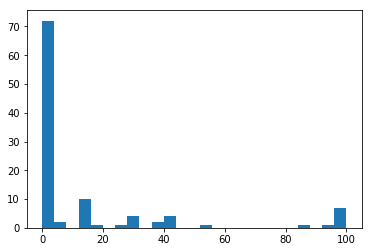

In [5]:
plt.hist(listings_null_percentage,bins = 25)

In [6]:
null_col_index = list(listings_null_percentage[listings_null_percentage>13].index)
print(null_col_index)

['space', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 'xl_picture_url', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_neighbourhood', 'neighbourhood_group_cleansed', 'square_feet', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'license']


#### DROP ABOVE COLS

In [7]:
listings = listings.drop(columns=null_col_index,axis=1)
listings.shape

(20677, 77)

In [8]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20677 entries, 0 to 20676
Data columns (total 77 columns):
id                                              20677 non-null int64
listing_url                                     20677 non-null object
scrape_id                                       20677 non-null int64
last_scraped                                    20677 non-null object
name                                            20642 non-null object
summary                                         20048 non-null object
description                                     20458 non-null object
experiences_offered                             20677 non-null object
picture_url                                     20677 non-null object
host_id                                         20677 non-null int64
host_url                                        20677 non-null object
host_name                                       20665 non-null object
host_since                                      20665 

In [9]:
listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'description', 'experiences_offered', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed', 'city', 'state',
       'zipcode', 'market', 'smart_location', 'country_code', 'country',
       'latitude', 'longitude', 'is_location_exact', 'property_type',
       'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'bed_type', 'amenities', 'price', 'guests_included', 'extra_people',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm

### Dropping initial columns
#### Columns with text will be removed as NLP is not being performed. For ex: name, summary, description, picture_url

In [10]:
cols_to_drop = ['listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'description', 'experiences_offered',
               'picture_url', 'host_id', 'host_url', 'host_name', 'host_location', 'host_thumbnail_url', 'host_picture_url',
               'host_verifications', 'calendar_last_scraped']

In [11]:
listings = listings.drop(columns=cols_to_drop,axis =1)
listings.shape

(20677, 61)

In [12]:
listings.isna().sum()

id                                                 0
host_since                                        12
host_is_superhost                                 12
host_listings_count                               12
host_total_listings_count                         12
host_has_profile_pic                              12
host_identity_verified                            12
street                                             0
neighbourhood                                    831
neighbourhood_cleansed                             0
city                                               4
state                                            219
zipcode                                          886
market                                            40
smart_location                                     0
country_code                                       0
country                                            0
latitude                                           0
longitude                                     

#### host_listings_count and host_total_listings_count are all the same except 12. These are Nan values.So, we can remove either one of the variables. Other columns which split these into type of property will also be dropped, as they will be highly correlated (one will be the total of the others).

In [13]:
print(sum((listings.host_listings_count==listings.host_total_listings_count)==False))
listings.loc[(listings.host_listings_count==listings.host_total_listings_count)==False][:5]

12


,id,host_since,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,first_review,last_review,requires_license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
2678,4806556,NaN,NaN,NaN,NaN,NaN,NaN,"Amsterdam, Noord-Holland, Netherlands",Oud-West,De Baarsjes - Oud-West,Amsterdam,Noord-Holland,1053 XE,Amsterdam,"Amsterdam, Netherlands",NL,Netherlands,52.36907,4.87250,t,Houseboat,Entire home/apt,4,1.0,1.0,2.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",$150.00,2,$30.00,3,30,3,3,30,30,3.0,30.0,2 months ago,t,0,0,0,0,107,13,2015-06-14,2019-04-26,f,"{Amsterdam,"" NL""}",f,f,strict_14_with_grace_period,f,f,1,1,0,0,2.11
3444,6345018,NaN,NaN,NaN,NaN,NaN,NaN,"Amsterdam, Noord-Holland, Netherlands",Oostelijke Eilanden en Kadijken,Centrum-Oost,Amsterdam,Noord-Holland,1018,Amsterdam,"Amsterdam, Netherlands",NL,Netherlands,52.36872,4.92736,t,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Wifi,Kitchen,Heating,""Smoke det...",$60.00,2,$10.00,3,10,3,3,10,10,3.0,10.0,43 months ago,t,0,0,0,0,20,0,2015-05-26,2016-02-07,f,"{Amsterdam,"" NL Zip Codes 2"","" Amsterdam"","" NL""}",f,f,strict_14_with_grace_period,f,f,1,1,0,0,0.39
4359,7833712,NaN,NaN,NaN,NaN,NaN,NaN,"Amsterdam, Noord-Holland, Netherlands",De Pijp,De Pijp - Rivierenbuurt,Amsterdam,Noord-Holland,1074 VD,Amsterdam,"Amsterdam, Netherlands",NL,Netherlands,52.35203,4.90761,t,Apartment,Entire home/apt,4,1.0,1.0,2.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,Kitchen,Heating,""...",$110.00,2,$30.00,2,1125,2,2,1125,1125,2.0,1125.0,13 months ago,t,0,0,0,0,11,0,2015-10-06,2017-02-27,f,"{Amsterdam,"" NL""}",f,f,moderate,f,f,1,1,0,0,0.24
4854,8770120,NaN,NaN,NaN,NaN,NaN,NaN,"Amsterdam, Noord-Holland, Netherlands",Bos en Lommer,Bos en Lommer,Amsterdam,Noord-Holland,1055,Amsterdam,"Amsterdam, Netherlands",NL,Netherlands,52.37769,4.84936,t,Apartment,Entire home/apt,4,1.0,2.0,2.0,Real Bed,"{TV,Internet,Wifi,Kitchen,""Buzzer/wireless int...",$95.00,4,$30.00,3,28,3,3,28,28,3.0,28.0,4 months ago,t,0,0,0,0,28,5,2015-12-29,2019-03-30,f,"{Amsterdam,"" NL Zip Codes 2"","" Amsterdam"","" NL""}",f,f,strict_14_with_grace_period,f,f,1,1,0,0,0.64
5463,9833390,NaN,NaN,NaN,NaN,NaN,NaN,"Amsterdam Zuid-Oost, Noord-Holland, Netherlands",NaN,Bijlmer-Oost,Amsterdam Zuid-Oost,Noord-Holland,1104,Amsterdam,"Amsterdam Zuid-Oost, Netherlands",NL,Netherlands,52.31459,4.98202,f,Apartment,Entire home/apt,4,1.0,2.0,2.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Wheelchair acces...",$129.00,2,$25.00,2,1125,2,2,1125,1125,2.0,1125.0,29 months ago,t,0,0,0,0,1,0,2016-05-06,2016-05-06,f,"{Amsterdam,"" NL Zip Codes 2""}",f,f,strict_14_with_grace_period,f,f,1,1,0,0,0.03


In [14]:
listings.drop(['host_total_listings_count', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes',
              'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms'],axis=1,inplace=True)

#### There are multiple columns for property location, including an attempt by the site that originally scraped the data to clean up the neighbourhood locations. Some of these columns can be dropped. Because all of the listings are in Amsterdam,Netherlands, columns relating to city and country can be dropped. <br />One column is kept for area, neighboorhood_cleansed. also jurisdiction names has no unique information. so we remove it.

In [15]:
listings.drop(['street', 'neighbourhood', 'city', 'state', 'zipcode', 'market', 'smart_location', 'country_code',
              'country', 'latitude', 'longitude', 'is_location_exact', 'jurisdiction_names'],axis=1,inplace=True)

In [17]:
listings.shape

(20677, 43)

#### There are multiple columns for minimum and maximum night stays, but the two main ones will be used as there are few differences between e.g. minimum_nights and minimum_minimum_nights. The latter presumably refers to the fact that min/max night stays can vary over the year. The default (i.e. most frequently applied) min/max night stay values will be used instead which are maximum_nights and minimum_nights.

In [18]:
listings.drop(['minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights',
              'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm'],axis=1, inplace=True)

In [19]:
listings.columns

Index(['id', 'host_since', 'host_is_superhost', 'host_listings_count',
       'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_cleansed', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'price',
       'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights',
       'calendar_updated', 'has_availability', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'number_of_reviews_ltm', 'first_review',
       'last_review', 'requires_license', 'instant_bookable',
       'is_business_travel_ready', 'cancellation_policy',
       'require_guest_profile_picture', 'require_guest_phone_verification',
       'reviews_per_month'],
      dtype='object')

#### Checking whether boolean and categorical features containing sufficient number for instances to make them worth including it Replacing 'f' and 't' with 0 and 1

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a23e6f240>,
      dtype=object)

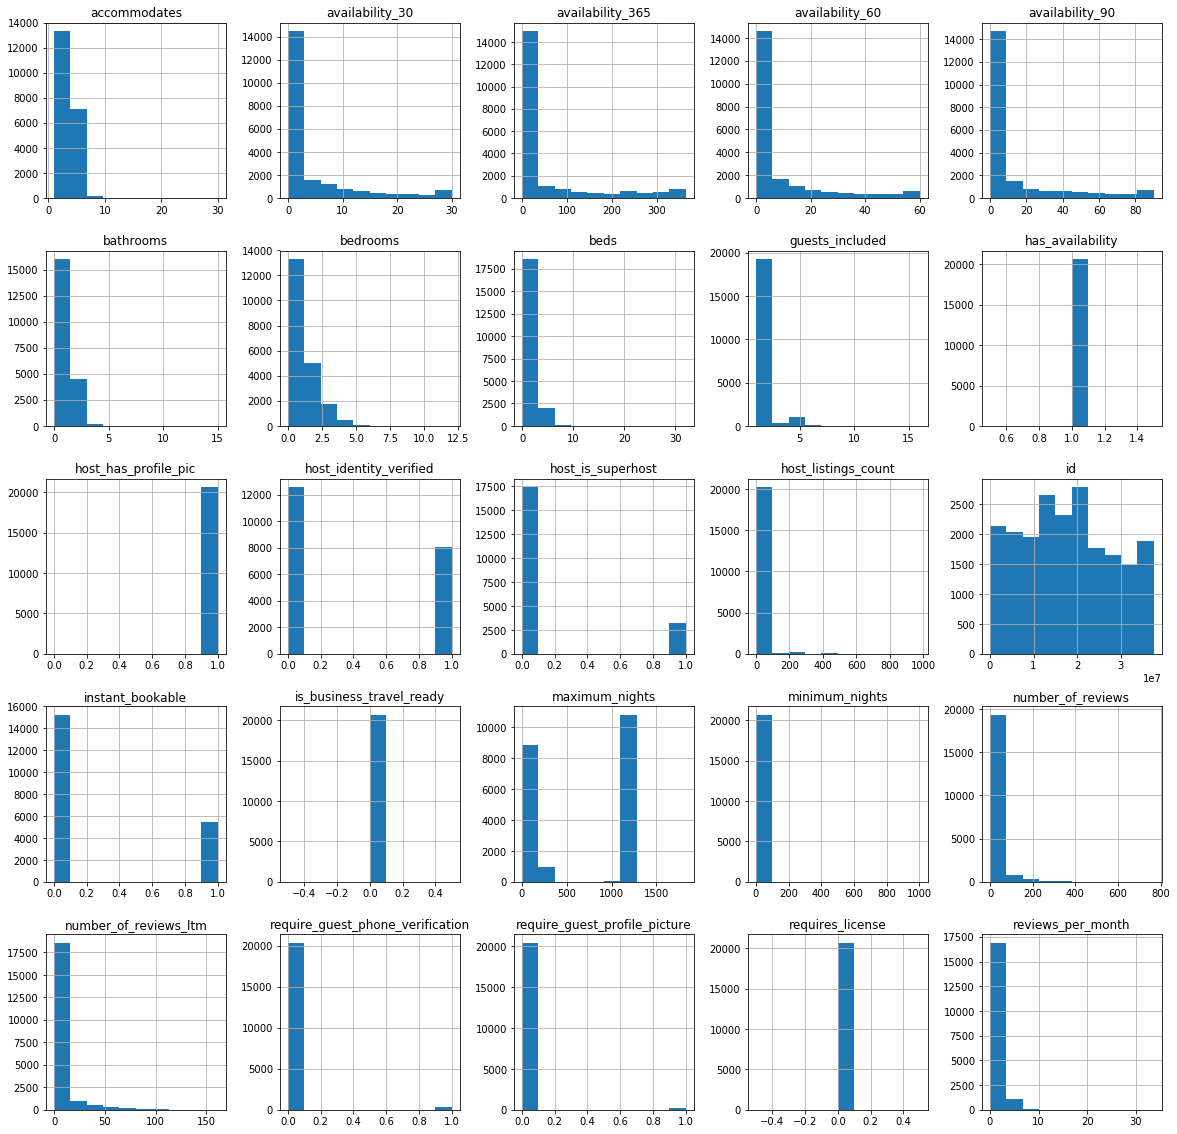

In [20]:
listings.replace({'f':0,'t':1},inplace=True)
listings.hist(figsize=(20,20))

#### Above it can be seen that many columns has only one category so they can be dropped

In [21]:
listings.drop(['has_availability', 'host_has_profile_pic', 'is_business_travel_ready',
              'require_guest_phone_verification', 'require_guest_profile_picture', 'requires_license'], axis=1, inplace=True)

### Variables Description
#### host_since - date when host first joined airbnb. <br /> host_is_super_host - whether or not the host is superhost, which is quality mark for top-rated and most experienceed hosts <br /> host_listings_count - how many hostings the host has in total. <br /> host_identity_verified - Whether or not host identity is verified <br /> neighbourhood_cleansed - The amsterdam neighbourhood the property is in <br /> property_type - type of property eg: house, flat <br /> room_type - type of listing eg:entire house, private room, shared room <br /> accommodates - how many people the property accommodates <br /> bathrooms - how many bathrooms are there <br /> bedrooms - how many bedrooms are there <br /> beds - how many beds are available <br /> bed_type - type of bed eg: real_bed or sofa bed <br /> amenities - list of amenities <br /> price - advertised price (Our target variable) <br /> guests_included - The number of guests included within booking fee <br /> extra_people - the price per additional guest above the guests_included price <br /> minimum_nights - minimum length of stay <br /> maximum_nights - maximum length of stay <br /> calendar_updated - when the host last updated the calender <br /> availability_30 - nights available to be booked in the next 30 days <br /> availability_60 - nights available to be booked in the next 60 days <br /> availability_90 - nights available to be booked in the next 90 days <br /> availability_365 - nights available to be booked in the next 365 days <br /> number_of_reviews - number of reviews left for the property <br /> number_of_reviews_ltm - number of reviews left for the property in the last 12 months <br /> first_review - date of the first review <br /> last_review - date of the most recent review <br /> instant_bookable - whether or not the property can be instant booked <br /> cancellation_policy - the type of cancellation policy eg: strict or flexible <br /> reviews_per_month - average number of reviews left by guest each month <br /> 

### host since- we create a new varible active days the host is since

In [22]:
listings.host_since = pd.to_datetime(listings.host_since)
listings['host_days_active']= (pd.datetime(2019, 8, 9) - listings.host_since).astype('timedelta64[D]')

In [25]:
listings.host_days_active.head()

0    3971.0
1    3537.0
2    3549.0
3    3426.0
4    3375.0
Name: host_days_active, dtype: float64

In [26]:
print("Mean days as host",round(listings['host_days_active'].mean(),0))
print("Median days as host",round(listings['host_days_active'].median(),0))

Mean days as host 1613.0
Median days as host 1650.0


#### There are 12 rows lacking values for each of four different host-related features. These rows will be dropped.

In [27]:
len(listings[listings.loc[:,['host_since', 'host_is_super_host','host_listings_count','host_identity_verified']].isnull().sum(axis=1)==4])

12

In [28]:
listings.dropna(subset=['host_since'],inplace=True)

#### property_type <br /><br />Some cleaning of property types is required as there are a large number of categories with only a few listings. The categories Apartment, House and Other will be used, as most properties can be classified as either apartment or house.

In [29]:
listings.property_type.value_counts()

Apartment                 15824
House                      1638
Townhouse                   671
Bed and breakfast           549
Loft                        392
Boat                        351
Condominium                 334
Houseboat                   289
Guest suite                 146
Aparthotel                  119
Serviced apartment           69
Guesthouse                   49
Boutique hotel               43
Other                        39
Villa                        39
Hostel                       29
Hotel                        23
Tiny house                   12
Cottage                      12
Cabin                        10
Camper/RV                     5
Bungalow                      3
Chalet                        3
Casa particular (Cuba)        3
Yurt                          2
Barn                          2
Lighthouse                    1
Campsite                      1
Tent                          1
Island                        1
Nature lodge                  1
Dome hou

In [30]:
listings.replace({'Townhouse':'House',
                 'Serviced apartment':'Apartment',
                 'Loft':'Apartment',
                 'Bungalow':'House',
                 'Cottage':'House',
                 'Villa':'House',
                 'Tiny house':'House',
                 'Earth house':'House',
                 'Chalet':'House'}, inplace = True)


##### Replacing other categories with 'other'

In [31]:
listings.loc[~listings.property_type.isin(['House','Apartment']),'property_type'] = 'Other'

##### bedrooms, bathrooms and beds

In [32]:
for col in ['bathrooms','bedrooms','beds']:
    listings[col].fillna(listings[col].median(), inplace = True)

##### bed_type
##### Most listings have the same bed type, so it won't constitute a comparative advantage to have this feature. So this feature can be dropped.

In [33]:
listings.bed_type.value_counts()

Real Bed         20486
Pull-out Sofa      119
Futon               40
Airbed              14
Couch                6
Name: bed_type, dtype: int64

In [34]:
listings.drop('bed_type',axis=1,inplace=True)

#### amenities
#### These are additional features in the property.

In [35]:
# Example of amenities
listings.amenities[:1].values

array(['{Internet,Wifi,"Paid parking off premises","Buzzer/wireless intercom",Heating,Washer,"Smoke detector","Carbon monoxide detector","First aid kit","Safety card","Fire extinguisher",Essentials,Shampoo,"Lock on bedroom door","24-hour check-in",Hangers,"Hair dryer",Iron,"Laptop friendly workspace","translation missing: en.hosting_amenity_49","translation missing: en.hosting_amenity_50","Private entrance","Hot water","Bed linens","Extra pillows and blankets","Single level home","Garden or backyard","No stairs or steps to enter","Flat path to guest entrance","Well-lit path to entrance","No stairs or steps to enter","Accessible-height bed","No stairs or steps to enter","Host greets you","Handheld shower head","Paid parking on premises"}'],
      dtype=object)

In [36]:
# Creating a set of all possible amenities
amenities_lst = list(listings.amenities)
amenities_lst_string = " ".join(amenities_lst)
amenities_lst_string = amenities_lst_string.replace('{', '')
amenities_lst_string = amenities_lst_string.replace('}', ',')
amenities_lst_string = amenities_lst_string.replace('"', '')
amenities_set = [x.strip() for x in amenities_lst_string.split(',')]
amenities_set = set(amenities_set)
amenities_set

{'',
 '24-hour check-in',
 'Accessible-height bed',
 'Accessible-height toilet',
 'Air conditioning',
 'Air purifier',
 'BBQ grill',
 'Baby bath',
 'Baby monitor',
 'Babysitter recommendations',
 'Bathtub',
 'Bathtub with bath chair',
 'Beach essentials',
 'Beachfront',
 'Bed linens',
 'Breakfast',
 'Building staff',
 'Buzzer/wireless intercom',
 'Cable TV',
 'Carbon monoxide detector',
 'Cat(s)',
 'Changing table',
 'Children’s books and toys',
 'Children’s dinnerware',
 'Cleaning before checkout',
 'Coffee maker',
 'Cooking basics',
 'Crib',
 'Disabled parking spot',
 'Dishes and silverware',
 'Dishwasher',
 'Dog(s)',
 'Doorman',
 'Dryer',
 'EV charger',
 'Electric profiling bed',
 'Elevator',
 'Essentials',
 'Ethernet connection',
 'Extra pillows and blankets',
 'Extra space around bed',
 'Family/kid friendly',
 'Fire extinguisher',
 'Fireplace guards',
 'Firm mattress',
 'First aid kit',
 'Fixed grab bars for shower',
 'Fixed grab bars for toilet',
 'Flat path to guest entrance',
 

#### Some amenities are more important than other for example: balcony is more likely to increase price than fax_machine. For this, amenities will be extracted a list which guests consider more important. In EDA, this can be explored. For example, if it turns out that almost all properties have/do not have a particular amenity, that feature will not be very useful in helping explain differences in prices.<br /> These are some amenities that are chosen: <br />24-hour check-in<br />Air conditioning/Central air conditioning<br />Amazon Echo/Apple TV/Game console/Netflix|Projector and screen/Smart TV<br />BBQ grill/Fire pit/Propane barbeque<br />Balcony/Patio<br />Beach view/Beachfront/Lake access/Mountain view/Ski-in/Ski-out/Waterfront<br />Bed linens<br />Breakfast<br />TV<br />Coffee maker/Espresso machine<br />Cooking basics<br />Dishwasher/Dryer/Washer<br />Elevator<br />Exercise equipment/Gym/gym<br />Family/kid friendly/Children/children<br />parking<br />Garden/Outdoor/Sun loungers/Terrace<br />Host greets you<br />Hot tub/Jetted tub/hot tub/Sauna/Pool/pool<br />Internet/Pocket wifi/Wifi<br />Long term stays allowed<br />Pets/pet/Cat(s)/Dog(s)<br />Private entrance<br />Safe/Security system<br />Self check-in<br />Smoking allowed<br />Step-free access/Wheelchair/Accessible<br />Suitable for events

In [37]:
listings.loc[listings['amenities'].str.contains('24-hour check-in'), 'check_in_24h'] = 1
listings.loc[listings['amenities'].str.contains('Air conditioning|Central air conditioning'), 'air_conditioning'] = 1
listings.loc[listings['amenities'].str.contains('Amazon Echo|Apple TV|Game console|Netflix|Projector and screen|Smart TV'), 'high_end_electronics'] = 1
listings.loc[listings['amenities'].str.contains('BBQ grill|Fire pit|Propane barbeque'), 'bbq'] = 1
listings.loc[listings['amenities'].str.contains('Balcony|Patio'), 'balcony'] = 1
listings.loc[listings['amenities'].str.contains('Beach view|Beachfront|Lake access|Mountain view|Ski-in/Ski-out|Waterfront'), 'nature_and_views'] = 1
listings.loc[listings['amenities'].str.contains('Bed linens'), 'bed_linen'] = 1
listings.loc[listings['amenities'].str.contains('Breakfast'), 'breakfast'] = 1
listings.loc[listings['amenities'].str.contains('TV'), 'tv'] = 1
listings.loc[listings['amenities'].str.contains('Coffee maker|Espresso machine'), 'coffee_machine'] = 1
listings.loc[listings['amenities'].str.contains('Cooking basics'), 'cooking_basics'] = 1
listings.loc[listings['amenities'].str.contains('Dishwasher|Dryer|Washer'), 'white_goods'] = 1
listings.loc[listings['amenities'].str.contains('Elevator'), 'elevator'] = 1
listings.loc[listings['amenities'].str.contains('Exercise equipment|Gym|gym'), 'gym'] = 1
listings.loc[listings['amenities'].str.contains('Family/kid friendly|Children|children'), 'child_friendly'] = 1
listings.loc[listings['amenities'].str.contains('parking'), 'parking'] = 1
listings.loc[listings['amenities'].str.contains('Garden|Outdoor|Sun loungers|Terrace'), 'outdoor_space'] = 1
listings.loc[listings['amenities'].str.contains('Host greets you'), 'host_greeting'] = 1
listings.loc[listings['amenities'].str.contains('Hot tub|Jetted tub|hot tub|Sauna|Pool|pool'), 'hot_tub_sauna_or_pool'] = 1
listings.loc[listings['amenities'].str.contains('Internet|Pocket wifi|Wifi'), 'internet'] = 1
listings.loc[listings['amenities'].str.contains('Long term stays allowed'), 'long_term_stays'] = 1
listings.loc[listings['amenities'].str.contains('Pets|pet|Cat(s)|Dog(s)'), 'pets_allowed'] = 1
listings.loc[listings['amenities'].str.contains('Private entrance'), 'private_entrance'] = 1
listings.loc[listings['amenities'].str.contains('Safe|Security system'), 'secure'] = 1
listings.loc[listings['amenities'].str.contains('Self check-in'), 'self_check_in'] = 1
listings.loc[listings['amenities'].str.contains('Smoking allowed'), 'smoking_allowed'] = 1
listings.loc[listings['amenities'].str.contains('Step-free access|Wheelchair|Accessible'), 'accessible'] = 1
listings.loc[listings['amenities'].str.contains('Suitable for events'), 'event_suitable'] = 1

#### One way to reduce the number of features is to remove the amenities which add relatively little information, or are relatively unhelpful in differentiating between different listings. Amenity features where either the true or the false category contains fewer than 10% of listings will be removed.

In [38]:
listings.iloc[:,31:].columns

Index(['check_in_24h', 'air_conditioning', 'high_end_electronics', 'bbq',
       'balcony', 'nature_and_views', 'bed_linen', 'breakfast', 'tv',
       'coffee_machine', 'cooking_basics', 'white_goods', 'elevator', 'gym',
       'child_friendly', 'parking', 'outdoor_space', 'host_greeting',
       'hot_tub_sauna_or_pool', 'internet', 'long_term_stays', 'pets_allowed',
       'private_entrance', 'secure', 'self_check_in', 'smoking_allowed',
       'accessible', 'event_suitable'],
      dtype='object')

In [39]:
# Replacing nulls with zeros for new columns
cols_to_replace_nulls = listings.iloc[:,31:].columns
listings[cols_to_replace_nulls] = listings[cols_to_replace_nulls].fillna(0)

# Produces a list of amenity features where one category (true or false) contains fewer than 10% of listings
infrequent_amenities = []
for col in listings.iloc[:,31:].columns:
    if listings[col].sum() < len(listings)/10:
        infrequent_amenities.append(col)
print(infrequent_amenities)

['check_in_24h', 'air_conditioning', 'high_end_electronics', 'bbq', 'nature_and_views', 'breakfast', 'elevator', 'gym', 'outdoor_space', 'hot_tub_sauna_or_pool', 'self_check_in', 'smoking_allowed', 'accessible', 'event_suitable']


In [40]:
# Dropping infrequent amenity features
listings.drop(infrequent_amenities, axis=1, inplace=True)

# Dropping the original amenity feature
listings.drop('amenities', axis=1, inplace=True)

In [41]:
listings.columns[30:]

Index(['balcony', 'bed_linen', 'tv', 'coffee_machine', 'cooking_basics',
       'white_goods', 'child_friendly', 'parking', 'host_greeting', 'internet',
       'long_term_stays', 'pets_allowed', 'private_entrance', 'secure'],
      dtype='object')

### Now Price is in string format because of currency sign. price will be converted to integer

In [42]:
listings['price'] = listings['price'].apply(lambda x : x.replace('$',''))
listings['price'] = listings['price'].apply(lambda x : x.replace(',',''))
listings['price'] = pd.to_numeric(listings['price'])

In [43]:
listings['price'] = listings.price.astype('int64')

### Similar to price extra_people is also converted to int

In [44]:
listings.extra_people = listings.extra_people.str[1:-3]
listings.extra_people = listings.extra_people.str.replace(",","")
listings.extra_people.fillna(0, inplace = True)
listings.extra_people = listings.extra_people.astype('int64')

#### calender_updated.<br /> There are 75 unique categories of calender_updated and it's not clear how this feature can help the model. we drop this feature

In [45]:
listings.drop('calendar_updated',axis=1,inplace=True)

#### availability.<br /> There are multiple measures of availability. These can be highly correlated to each other.Only one will be retained, availability for 30 days (availability_30). This is due to the seemingly inevitable enforcement of Newyork-like regulations proposed by the Netherlands Government (30 days per year rents) 

In [46]:
listings.drop(['availability_60','availability_90','availability_365'],axis=1,inplace=True)

#### First review and Last review

In [47]:
print(f"Null Values in first_review:{round(100*listings.first_review.isna().sum()/len(listings),1)}%")

Null Values in first_review:12.5%


In [48]:
listings.first_review = pd.to_datetime(listings.first_review)
# Calculating the number of days between first reviewe and the data scraped
listings['time_since_first_review'] = (pd.datetime(2019, 8, 9) - listings.first_review).astype('timedelta64[D]')

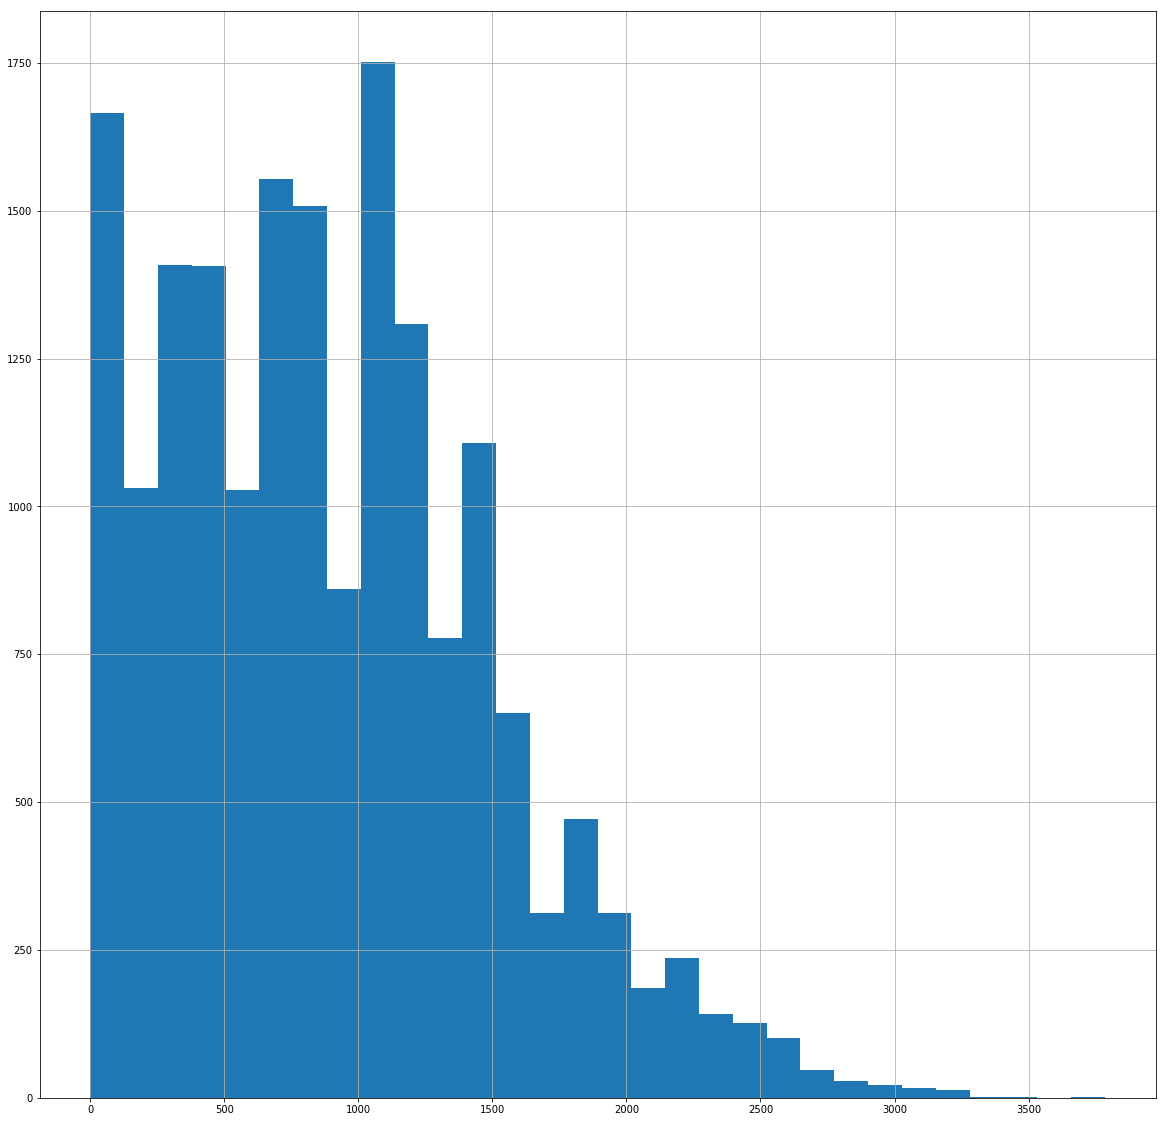

In [49]:
listings.time_since_first_review.hist(figsize=(20,20),bins = 30)

In [50]:
def bin_column(col, bins, labels, na_label='unknown'):
    """
    Takes in a column name, bin cut points and labels, replaces the original column with a
    binned version, and replaces nulls (with 'unknown' if unspecified).
    """
    listings[col] = pd.cut(listings[col], bins=bins, labels=labels, include_lowest=True)
    listings[col] = listings[col].astype('str')
    listings[col].fillna(na_label, inplace=True)

In [51]:
# Binning time_since_first_review
bin_column('time_since_first_review',
           bins=[0, 182, 365, 730, 1460, max(listings.time_since_first_review)],
           labels=['0-6 months',
                   '6-12 months',
                   '1-2 years',
                   '2-3 years',
                   '4+ years'],
           na_label='no reviews')

#### Same process for last review

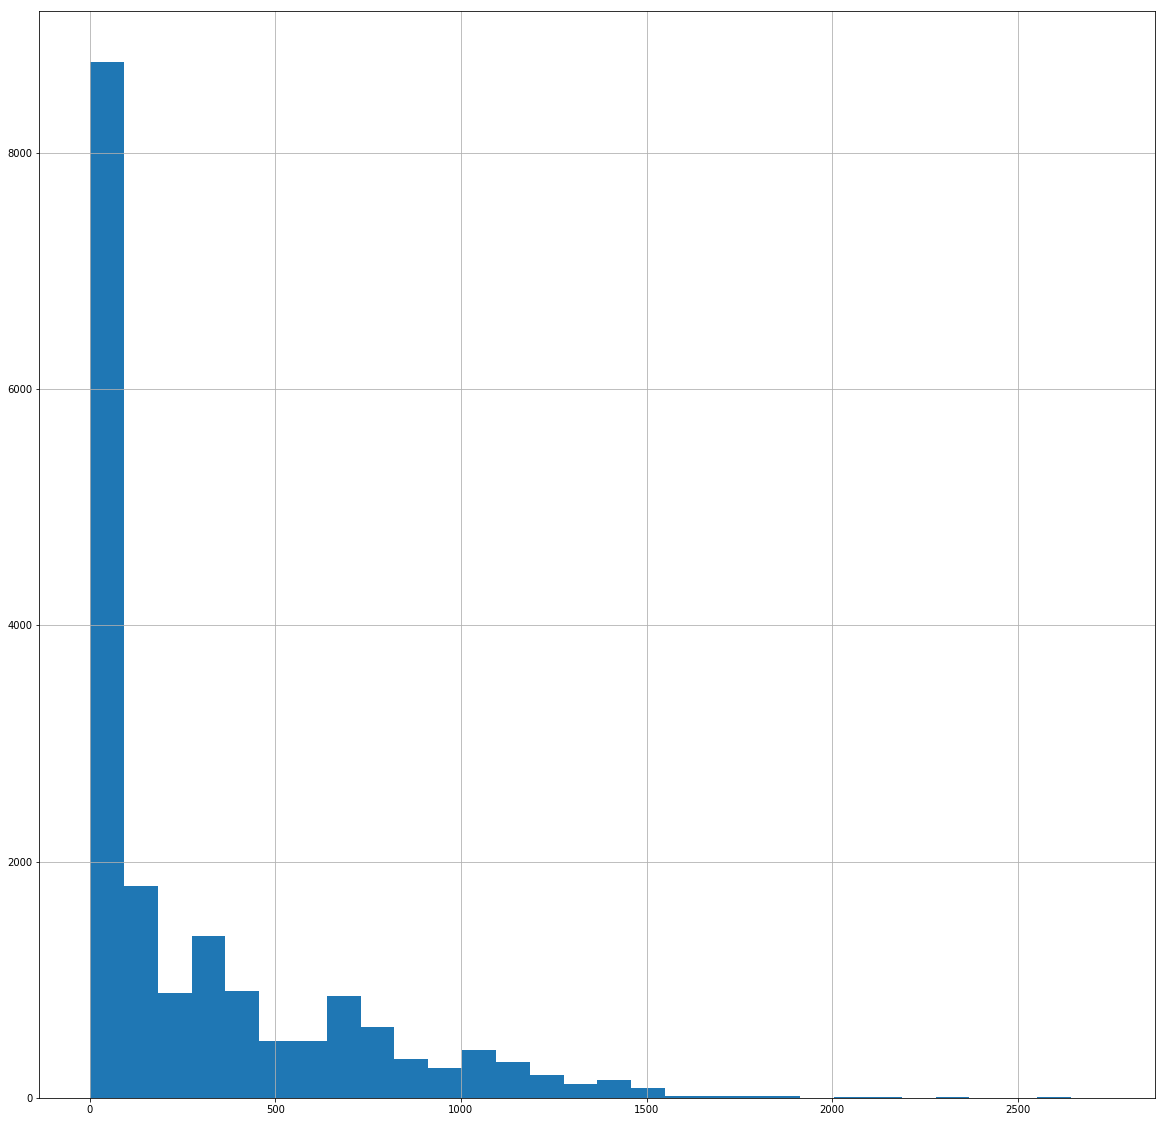

In [52]:
listings.last_review= pd.to_datetime(listings.last_review)
listings['time_since_last_review'] = (pd.datetime(2019,8,9)-listings.last_review).astype('timedelta64[D]')
listings.time_since_last_review.hist(figsize=(20,20),bins =30)

In [53]:
bin_column('time_since_last_review',
          bins = [0,14,60,182,365,max(listings.time_since_last_review)],
          labels=['0-2 weeks','2-8 weeks','2-6 months','6-12 months','1+year'],
          na_label='no reviews')

In [54]:
listings.drop('last_review',axis=1,inplace=True)

#### cancellation policy<br />In order to categorise the four very small categories into the three larger categories (e.g. the super strict options are only available to long-term Airbnb hosts, and is invitation only).

In [55]:
listings.cancellation_policy.value_counts()

strict_14_with_grace_period    7998
moderate                       7488
flexible                       5040
super_strict_60                 112
super_strict_30                  26
Name: cancellation_policy, dtype: int64

In [56]:
listings.cancellation_policy.replace({
    'super_strict_30': 'strict_14_with_grace_period',
    'super_strict_60': 'strict_14_with_grace_period',
    'strict': 'strict_14_with_grace_period',
    'luxury_moderate': 'moderate'
    }, inplace=True)

#### number of reviews_ltm and reviews per month will be highly correlated with number of reviews, so it will be dropped

In [57]:
listings.drop(['number_of_reviews_ltm','reviews_per_month'], axis=1,inplace=True)

In [58]:
listings.head()
listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20665 entries, 0 to 20676
Data columns (total 39 columns):
id                         20665 non-null int64
host_since                 20665 non-null datetime64[ns]
host_is_superhost          20665 non-null float64
host_listings_count        20665 non-null float64
host_identity_verified     20665 non-null float64
neighbourhood_cleansed     20665 non-null object
property_type              20665 non-null object
room_type                  20665 non-null object
accommodates               20665 non-null int64
bathrooms                  20665 non-null float64
bedrooms                   20665 non-null float64
beds                       20665 non-null float64
price                      20665 non-null int64
guests_included            20665 non-null int64
extra_people               20665 non-null int64
minimum_nights             20665 non-null int64
maximum_nights             20665 non-null int64
availability_30            20665 non-null int64
num

## Exploratory Data Analysis
### Time series
#### Time is an important factor to consider in a model when we wish to predict prices or trends.<br /> For airbnb high seasonality is expected due to the market.

In [59]:
listings['host_since']= pd.to_datetime(listings['host_since'])
listings['first_review'] = pd.to_datetime(listings['first_review'])
x=min(listings.host_since).strftime('%d %B %Y')
y=max(listings.host_since).strftime('%d %B %Y')
print(f"Of the Airbnb hosts that are still listing on the site, the first joined on",x,"and the most recent joined on",y)

Of the Airbnb hosts that are still listing on the site, the first joined on 24 September 2008 and the most recent joined on 08 August 2019


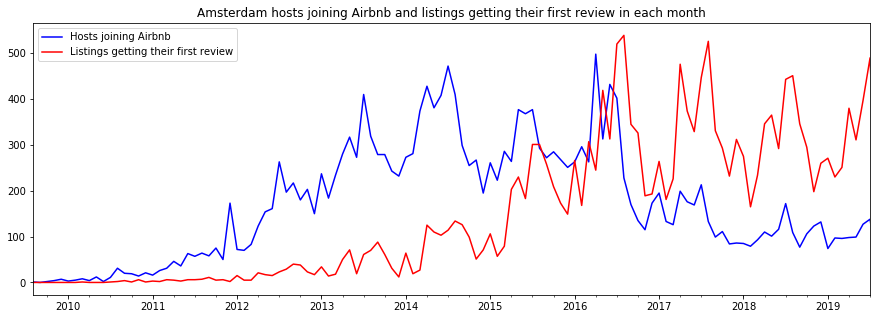

In [60]:
plt.figure(figsize=(15,5))
listings.set_index('host_since').resample('MS').size().plot(label='Hosts joining Airbnb', color='blue')
listings.set_index('first_review').resample('MS').size().plot(label='Listings getting their first review', color='red')
plt.title('Amsterdam hosts joining Airbnb and listings getting their first review in each month')
plt.legend()
plt.xlim('2009-08-21', '2019-07-20') # Limiting to whole months
plt.xlabel('')
plt.ylabel('')
plt.show()

In [61]:
# Creating dataframes for time series analysis
ts_host_since = pd.DataFrame(listings.set_index('host_since').resample('MS').size())
ts_first_review = pd.DataFrame(listings.set_index('first_review').resample('MS').size())

# Renaming columns
ts_host_since = ts_host_since.rename(columns={0: 'hosts'})
ts_host_since.index.rename('month', inplace=True)
ts_first_review = ts_first_review.rename(columns={0: 'reviews'})
ts_first_review.index.rename('month', inplace=True)

In [62]:
import datetime
from statsmodels.tsa.seasonal import seasonal_decompose

In [63]:
def decompose_time_series(df, title=''):
    """
    Plots the original time series and its decomposition into trend, seasonal and residual.
    """
    # Decomposing the time series
    decomposition = seasonal_decompose(df)
    
    # Getting the trend, seasonality and noise
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    # Plotting the original time series and the decomposition
    plt.figure(figsize=(12,8))
    plt.suptitle(title, fontsize=14, y=1)
    plt.subplots_adjust(top=0.80)
    plt.subplot(411)
    plt.plot(df, label='Original')
    plt.legend(loc='upper left')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='upper left')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='upper left')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='upper left')
    plt.tight_layout()

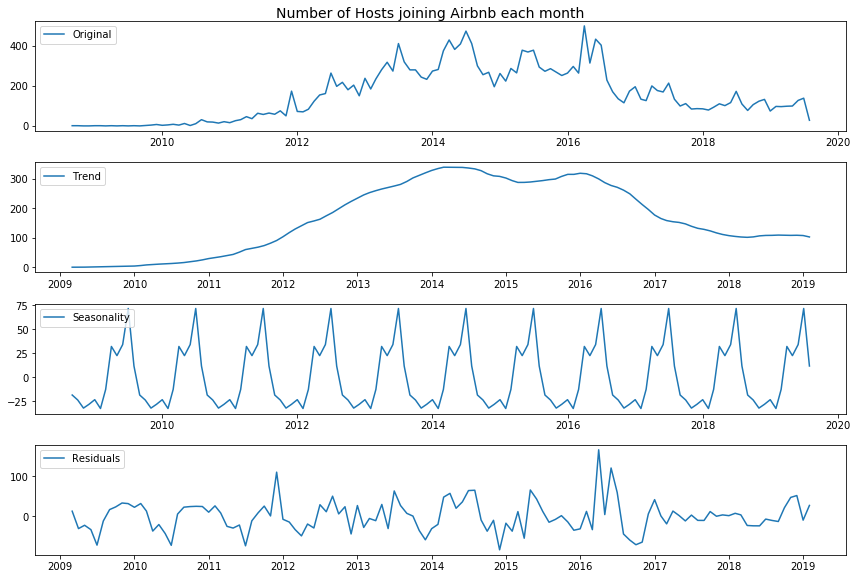

In [64]:
decompose_time_series(ts_host_since,title ='Number of Hosts joining Airbnb each month')

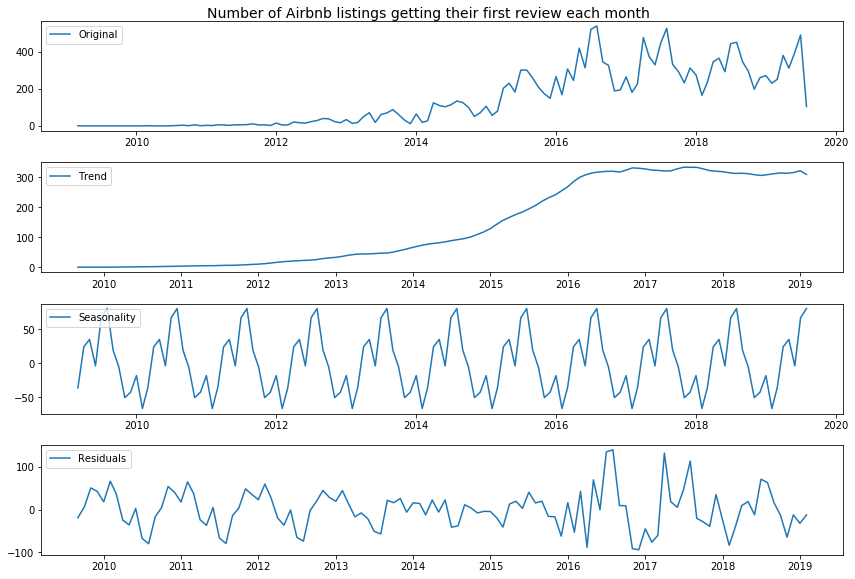

In [65]:
decompose_time_series(ts_first_review, title='Number of Airbnb listings getting their first review each month')

### As seen above, there is a clear seasonality. Every year, you see a peak towards hosts joining around the middle of the year (summer), and the lowest points are the beginning and the end of each year. There has been huge peak of number of hosts joining airbnb in early 2016 and a sudden steep after that. This is because therer have been rising concerns about airbnb's regulations in cities like amsterdam accused of driving up property prices and disrupting communities. <br />After that there has been significant decrease in number of hosts joining airbnb. This is because There have been regulations in early 2017 that hosts can rentout their home not more than 60 days per single year, the airbnb systems automatically limiting and implementing these regulations and this short term is cut down to 30 nights per year in mid 2018. This can be the main reason the number has been sharply decreasing.

### Another important pattern to observe is the number of listings per owner/host. There are a number of professional Airbnb management companies which host a large number of listings under a single host profile. However, there is no consistent upwards trend in the average number of properties managed by each host.

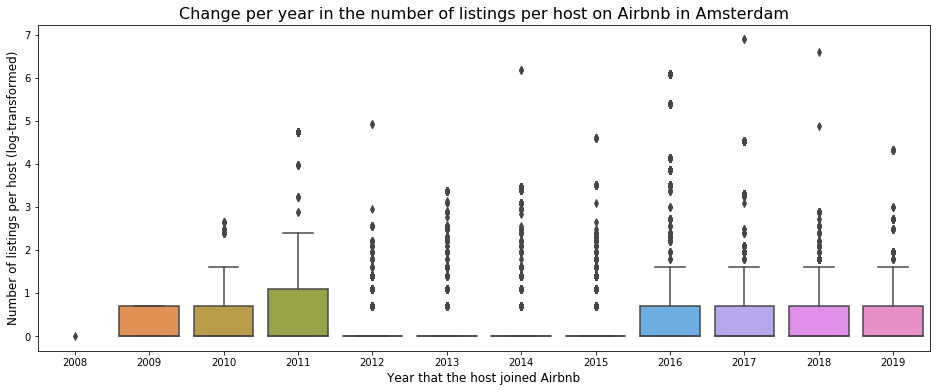

In [66]:
plt.figure(figsize=(16,6))
sns.boxplot(listings.host_since.dt.year, np.log(listings.host_listings_count))
plt.xlabel('Year that the host joined Airbnb', fontsize=12)
plt.ylabel('Number of listings per host (log-transformed)', fontsize=12)
plt.title('Change per year in the number of listings per host on Airbnb in Amsterdam', fontsize=16)
plt.show()

In [67]:
print("Average number of listings per host per year on Airbnb in Amsterdam:")
print(round(listings.set_index('host_since').host_listings_count.resample('YS').mean(),2))

Average number of listings per host per year on Airbnb in Amsterdam:
host_since
2008-01-01     0.50
2009-01-01     1.39
2010-01-01     2.71
2011-01-01    19.52
2012-01-01     1.65
2013-01-01     1.74
2014-01-01     2.19
2015-01-01     1.78
2016-01-01    27.16
2017-01-01     6.71
2018-01-01     2.87
2019-01-01     3.12
Freq: AS-JAN, Name: host_listings_count, dtype: float64


In [68]:
# List of the largest host_listings_count and the year the host joined Airbnb
listings.sort_values('host_listings_count').drop_duplicates('host_listings_count',keep='last').tail(10)[['host_since', 'host_listings_count']]

,host_since,host_listings_count
16900,2017-01-30,93.0
13610,2015-10-16,99.0
8829,2011-12-02,115.0
18381,2018-07-12,131.0
15826,2012-07-07,139.0
16397,2016-04-05,217.0
13900,2016-06-06,435.0
12752,2014-08-12,486.0
20651,2018-03-12,739.0
14445,2017-03-22,980.0


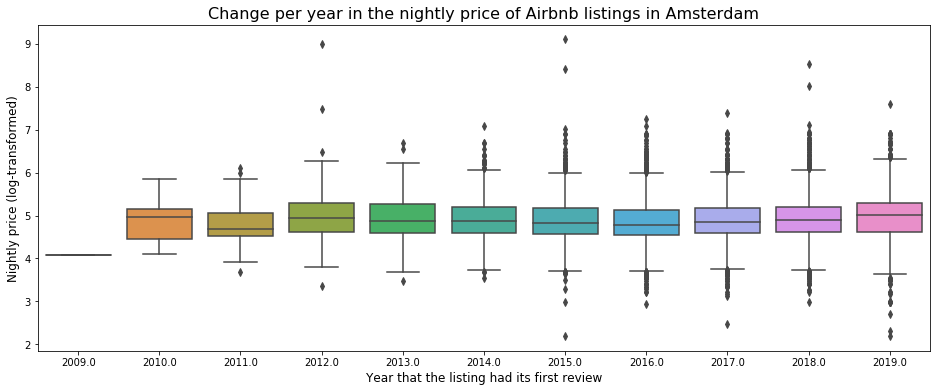

In [69]:
plt.figure(figsize=(16,6))
sns.boxplot(listings.first_review.dt.year, np.log(listings.price))
plt.xlabel('Year that the listing had its first review', fontsize=12)
plt.ylabel('Nightly price (log-transformed)', fontsize=12)
plt.title('Change per year in the nightly price of Airbnb listings in Amsterdam', fontsize=16)
plt.show()

In [70]:
print("Mean nightly price of listings in each year on Airbnb in Amsterdam:")
print(round(listings.set_index('first_review').price.resample('YS').mean(),2))

Mean nightly price of listings in each year on Airbnb in Amsterdam:
first_review
2009-01-01     59.00
2010-01-01    149.44
2011-01-01    135.00
2012-01-01    198.24
2013-01-01    157.40
2014-01-01    154.58
2015-01-01    153.88
2016-01-01    143.49
2017-01-01    147.80
2018-01-01    157.63
2019-01-01    166.93
Name: price, dtype: float64


In [71]:
# Drop host_since and first_review
listings.drop(['host_since','first_review'],axis=1,inplace=True)

In [72]:
listings.set_index('id', inplace=True)

In [73]:
listings.describe()

,host_is_superhost,host_listings_count,host_identity_verified,accommodates,bathrooms,bedrooms,beds,price,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,number_of_reviews,instant_bookable,host_days_active,balcony,bed_linen,tv,coffee_machine,cooking_basics,white_goods,child_friendly,parking,host_greeting,internet,long_term_stays,pets_allowed,private_entrance,secure
count,20665.000000,20665.000000,20665.000000,20665.000000,20665.000000,20665.000000,20665.000000,20665.000000,20665.000000,20665.000000,20665.000000,20665.000000,20665.000000,20665.000000,20665.000000,20665.000000,20665.000000,20665.000000,20665.000000,20665.000000,20665.000000,20665.000000,20665.000000,20665.000000,20665.000000,20665.000000,20665.000000,20665.000000,20665.000000,20665.000000
mean,0.155529,7.010888,0.390177,2.879264,1.158602,1.454295,1.829083,159.100073,1.459279,11.328768,3.547641,617.636245,3.782434,23.291459,0.263634,1613.134914,0.196806,0.325913,0.783644,0.303508,0.286039,0.802129,0.416985,0.387418,0.279700,0.976530,0.119090,0.118122,0.320203,0.118074
std,0.362417,37.729548,0.487802,1.315130,0.380131,0.894911,1.407737,162.500281,0.935698,23.153752,18.695770,537.973148,7.216388,48.628025,0.440614,717.148388,0.397594,0.468726,0.411770,0.459784,0.451919,0.398404,0.493072,0.487172,0.448863,0.151393,0.323903,0.322761,0.466566,0.322704
min,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,2.000000,1.000000,1.000000,1.000000,99.000000,1.000000,0.000000,2.000000,21.000000,0.000000,2.000000,0.000000,1148.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,2.000000,1.000000,1.000000,1.000000,130.000000,1.000000,0.000000,2.000000,1125.000000,0.000000,9.000000,0.000000,1650.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,2.000000,1.000000,4.000000,1.000000,2.000000,2.000000,180.000000,2.000000,20.000000,3.000000,1125.000000,4.000000,23.000000,1.000000,2152.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,980.000000,1.000000,30.000000,15.000000,12.000000,32.000000,8915.000000,16.000000,280.000000,1001.000000,1825.000000,30.000000,767.000000,1.000000,3971.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Price(Our Target Variable)
#### Looking at price distribution, advertised prices range from £0 to £8915. The extreme ends of the range are due to hosts not understanding how to use Airbnb advertised prices correctly. The advertised prices can be set to any arbitrary amount, and these are the prices that show when dates are not entered on the site. Once you enter the dates you want to occupy the property, prices can vary a lot.

In [74]:
print(f"Advertised prices range from £{min(listings.price)} to £{max(listings.price)}.")

Advertised prices range from £0 to £8915.


#### There are notable drop-offs in prices at £210 (first graph, red line) £500 (second graph, green line) and £1,000 (second graph, red line). Values above £1,000 will be reduced to £1,000.

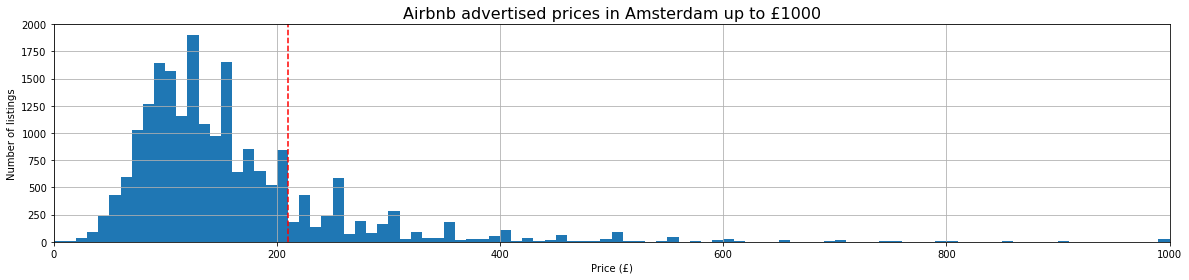

In [75]:
# Distribution of prices from £0 to £1000
plt.figure(figsize=(20,4))
listings.price.hist(bins=100, range=(0,1000))
plt.margins(x=0)
plt.axvline(210, color='red', linestyle='--')
plt.title("Airbnb advertised prices in Amsterdam up to £1000", fontsize=16)
plt.xlabel("Price (£)")
plt.ylabel("Number of listings")
plt.show()

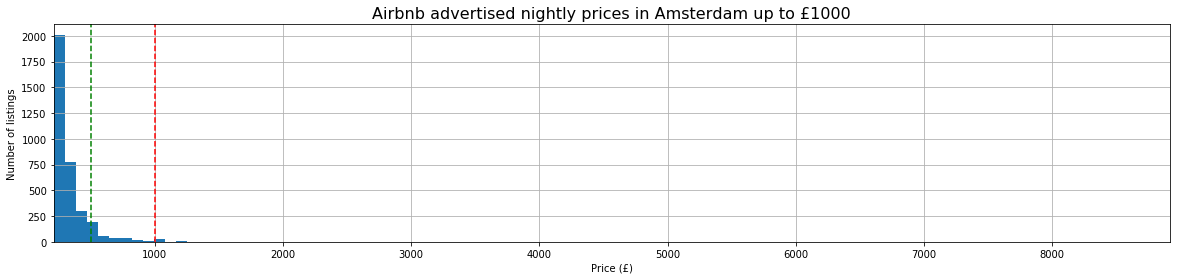

In [76]:
# Distribution of prices from £210 upwards
plt.figure(figsize=(20,4))
listings.price.hist(bins=100, range=(210, max(listings.price)))
plt.margins(x=0)
plt.axvline(500, color='green', linestyle='--')
plt.axvline(1000, color='red', linestyle='--')
plt.title("Airbnb advertised nightly prices in Amsterdam up to £1000", fontsize=16)
plt.xlabel("Price (£)")
plt.ylabel("Number of listings")
plt.show()

In [77]:
# Replacing values under £10 with £10
listings.loc[listings.price <= 10, 'price'] = 10

# Replacing values over £1000 with £1000
listings.loc[listings.price >= 1000, 'price'] = 1000

### hosts_listings_count
#### The median number of listings that the host of each listing has is 1. This means that on average (median) each listing is hosted by a host who only manages that listing. The mean is higher (7) due to some hosts managing some (very) large numbers of listings, as discussed above in the Time Series section. For example, the host with the highest number of listings has 980 listings under its ID. About half of listings are from hosts with one listing, and half are from multi-listing hosts.

#### Two difficulties in discerning how many listings hosts have on average are:

1) this number is only known on the level of the listing, so hosts with more listings are represented more frequently (e.g a host with 10 listings may be represented up to 10 times in the dataset)

2) a host's other listings may not be in Amsterdam, so some multi-listing hosts may appear multiple times in the dataset, and others may appear only once

In [78]:
print("Median number of listings per host:", int(listings.host_listings_count.median()))
print("Mean number of listings per host:", int(round(listings.host_listings_count.mean())))
print("Highest number of listins per host:", int(round(listings.host_listings_count.max())))
print(f"{int(round(100*len(listings[listings.host_listings_count == 1])/len(listings)))}% of listings are from hosts with one listing.")

Median number of listings per host: 1
Mean number of listings per host: 7
Highest number of listins per host: 980
72% of listings are from hosts with one listing.


### accommodates, bathrooms, bedrooms, beds
The most common property setup sleeps two people in one bed in one bedroom, with one bathroom. Unsurprisingly, properties that accommodate more people achieve noticeably higher rates per night, with diminishing returns coming after about 10 people.

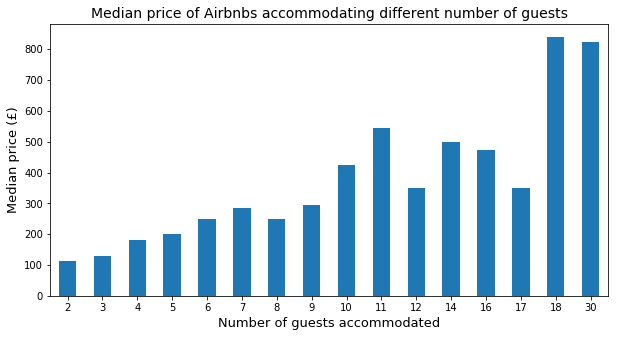

In [79]:
plt.figure(figsize=(10,5))
listings.groupby('accommodates').price.median().plot(kind='bar',color='C0')
plt.title('Median price of Airbnbs accommodating different number of guests', fontsize=14)
plt.xlabel('Number of guests accommodated', fontsize=13)
plt.ylabel('Median price (£)', fontsize=13)
plt.xticks(rotation=0)
plt.xlim(left=0.5)
plt.show()

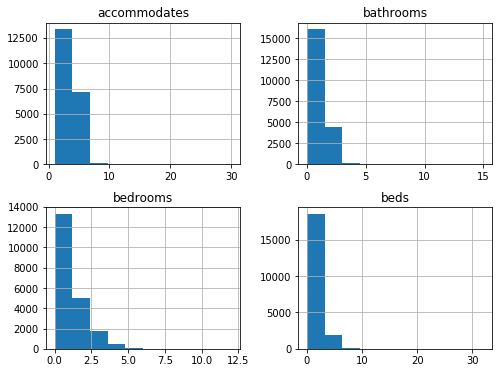

In [80]:
listings[['accommodates', 'bathrooms', 'bedrooms', 'beds']].hist(figsize=(8,6));

### Property_type and room_type
About 80% of properties are apartments/flats. The remainder are houses or more uncommon property types (e.g. bed and breakfast).About 75% of listings are entire homes (i.e. you are renting the entire property on your own). Most of the remainder are private rooms (i.e. you are renting a bedroom and possibly also a bathroom, but there will be other people in the property).Fewer than 5% are shared rooms (i.e. you are sharing a room with either the property owner or other guests).

In [81]:
def category_count_plot(col, figsize=(8,4)):
    """
    Plots a simple bar chart of the total count for each category in the column specified.
    A figure size can optionally be specified.
    """
    plt.figure(figsize=figsize)
    listings[col].value_counts().plot(kind='bar',color='C0')
    plt.title(col)
    plt.xticks(rotation=0)
    plt.show()

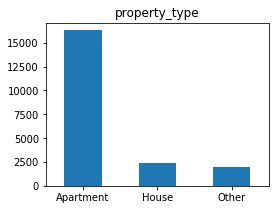

Apartment    0.788047
House        0.115122
Other        0.096830
Name: property_type, dtype: float64


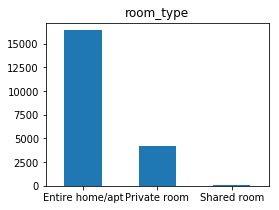

Entire home/apt    0.79337
Private room       0.20271
Shared room        0.00392
Name: room_type, dtype: float64


In [82]:
for col in ['property_type', 'room_type']:
    category_count_plot(col, figsize=(4,3))
    print(listings[col].value_counts(normalize=True))

### first_review and last_review
The most common time period in which currently live Airbnb listings had their first review is 2-3 years. This means that a lot of listings on the site have been active for at least a couple of years. Surprisingly some properties have no reviews in time_since_first_review which account for 10% of all and same goes for time_since_last_review. 

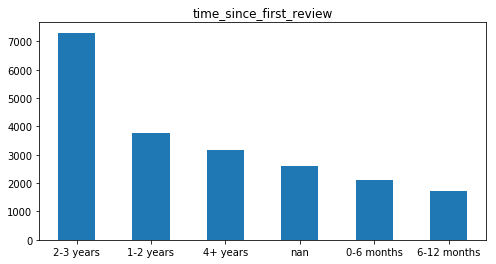

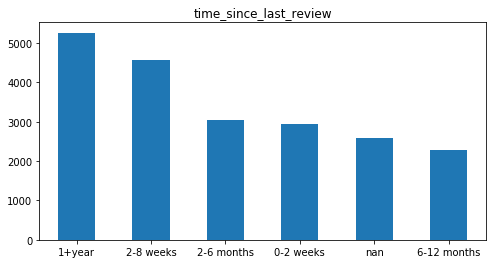

In [83]:
for col in ['time_since_first_review', 'time_since_last_review']:
    category_count_plot(col)

### Preparing data for modelling

Dropping columns and assessing multi-collinearity
Categorical variables will now be one-hot encoded:

In [84]:
transformed_df = pd.get_dummies(listings)
transformed_df.head()

,host_is_superhost,host_listings_count,host_identity_verified,accommodates,bathrooms,bedrooms,beds,price,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,number_of_reviews,instant_bookable,host_days_active,balcony,bed_linen,tv,coffee_machine,cooking_basics,white_goods,child_friendly,parking,host_greeting,internet,long_term_stays,pets_allowed,private_entrance,secure,neighbourhood_cleansed_Bijlmer-Centrum,neighbourhood_cleansed_Bijlmer-Oost,neighbourhood_cleansed_Bos en Lommer,neighbourhood_cleansed_Buitenveldert - Zuidas,neighbourhood_cleansed_Centrum-Oost,neighbourhood_cleansed_Centrum-West,neighbourhood_cleansed_De Aker - Nieuw Sloten,neighbourhood_cleansed_De Baarsjes - Oud-West,neighbourhood_cleansed_De Pijp - Rivierenbuurt,neighbourhood_cleansed_Gaasperdam - Driemond,neighbourhood_cleansed_Geuzenveld - Slotermeer,neighbourhood_cleansed_IJburg - Zeeburgereiland,neighbourhood_cleansed_Noord-Oost,neighbourhood_cleansed_Noord-West,neighbourhood_cleansed_Oostelijk Havengebied - Indische Buurt,neighbourhood_cleansed_Osdorp,neighbourhood_cleansed_Oud-Noord,neighbourhood_cleansed_Oud-Oost,neighbourhood_cleansed_Slotervaart,neighbourhood_cleansed_Watergraafsmeer,neighbourhood_cleansed_Westerpark,neighbourhood_cleansed_Zuid,property_type_Apartment,property_type_House,property_type_Other,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict_14_with_grace_period,time_since_first_review_0-6 months,time_since_first_review_1-2 years,time_since_first_review_2-3 years,time_since_first_review_4+ years,time_since_first_review_6-12 months,time_since_first_review_nan,time_since_last_review_0-2 weeks,time_since_last_review_1+year,time_since_last_review_2-6 months,time_since_last_review_2-8 weeks,time_since_last_review_6-12 months,time_since_last_review_nan
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2818,1.0,1.0,0.0,2,1.5,1.0,2.0,59,1,20,3,15,8,267,1,3971.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0
20168,0.0,2.0,0.0,2,1.0,1.0,1.0,80,2,0,1,1000,0,283,0,3537.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0
25428,0.0,2.0,0.0,3,1.0,1.0,1.0,125,2,10,14,60,4,3,0,3549.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0
27886,1.0,1.0,1.0,2,1.0,1.0,1.0,150,1,0,2,730,6,195,1,3426.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0
28871,1.0,3.0,1.0,2,1.0,1.0,1.0,75,1,0,2,1825,2,283,0,3375.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0


In [85]:
def multi_collinearity_heatmap(df, figsize=(11,9)):
    
    """
    Creates a heatmap of correlations between features in transformed_df.
    """
    
    # Set the style of the visualization
    sns.set(style="white")

    # Create a covariance matrix
    corr = df.corr()

    # Generate a mask the size of our covariance matrix
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmax=corr[corr != 1.0].max().max());

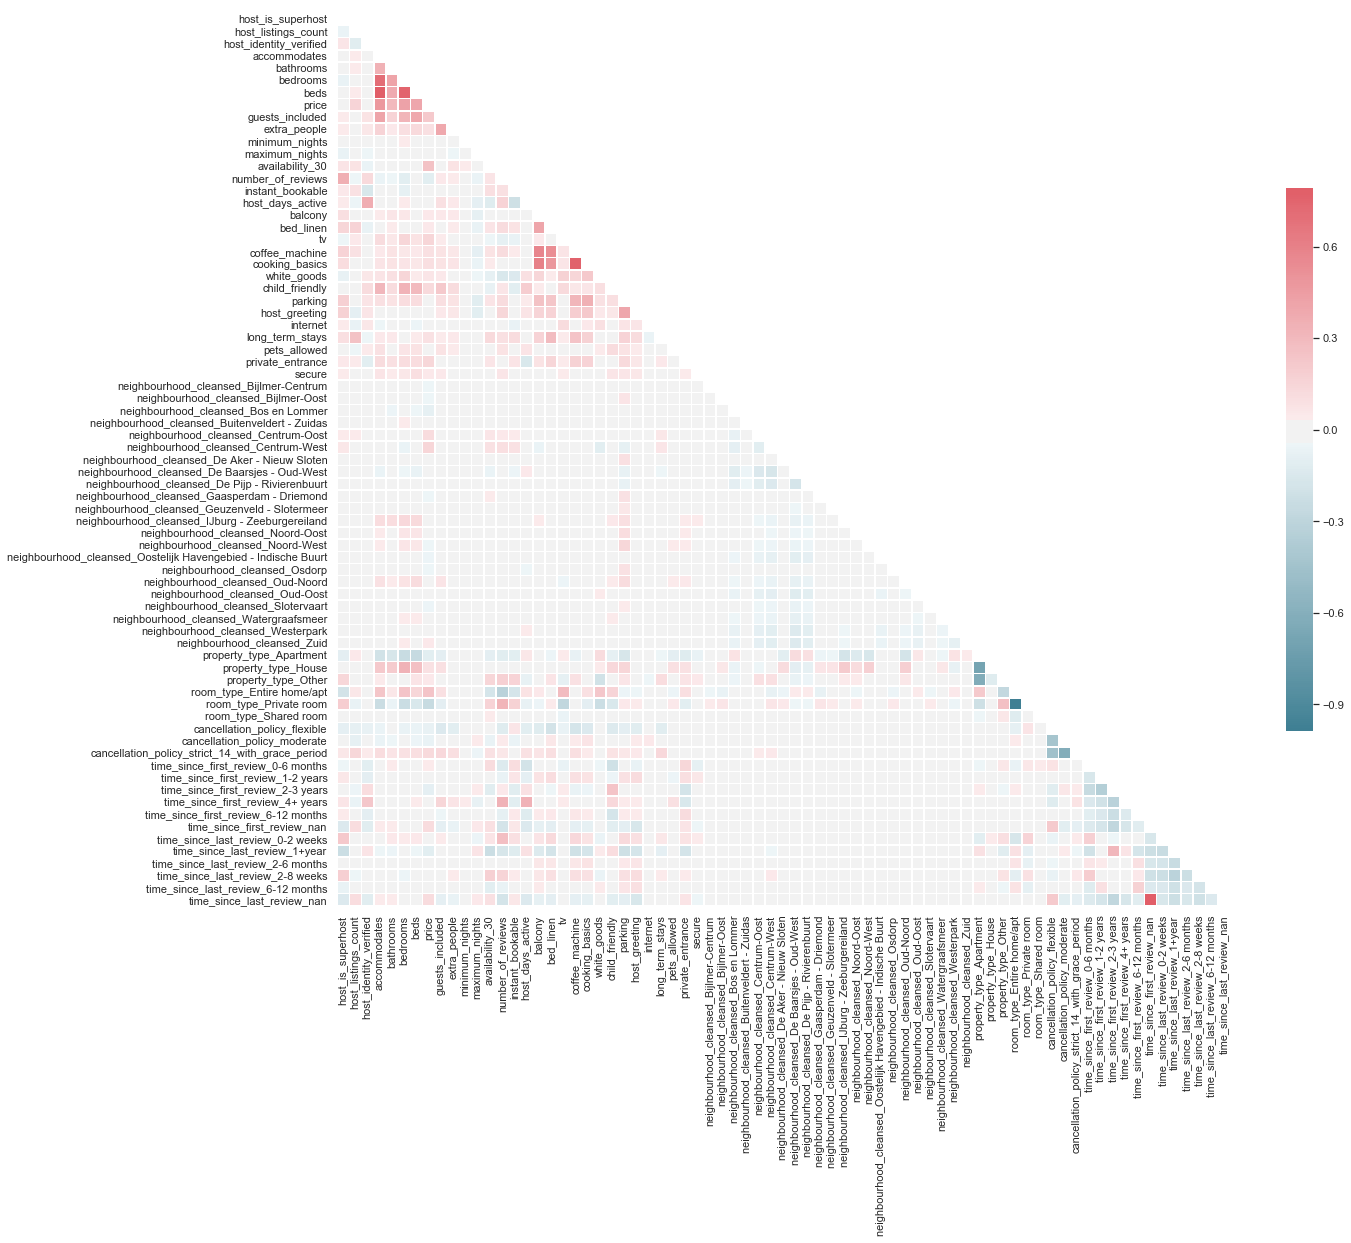

In [86]:
multi_collinearity_heatmap(transformed_df, figsize=(20,20))

#### It can be seen that there are any significant collinear relationships between neighbourhood variables, so it can be dropped. so these will temporarily be dropped to produce a clearer heatmap for the remaining features:

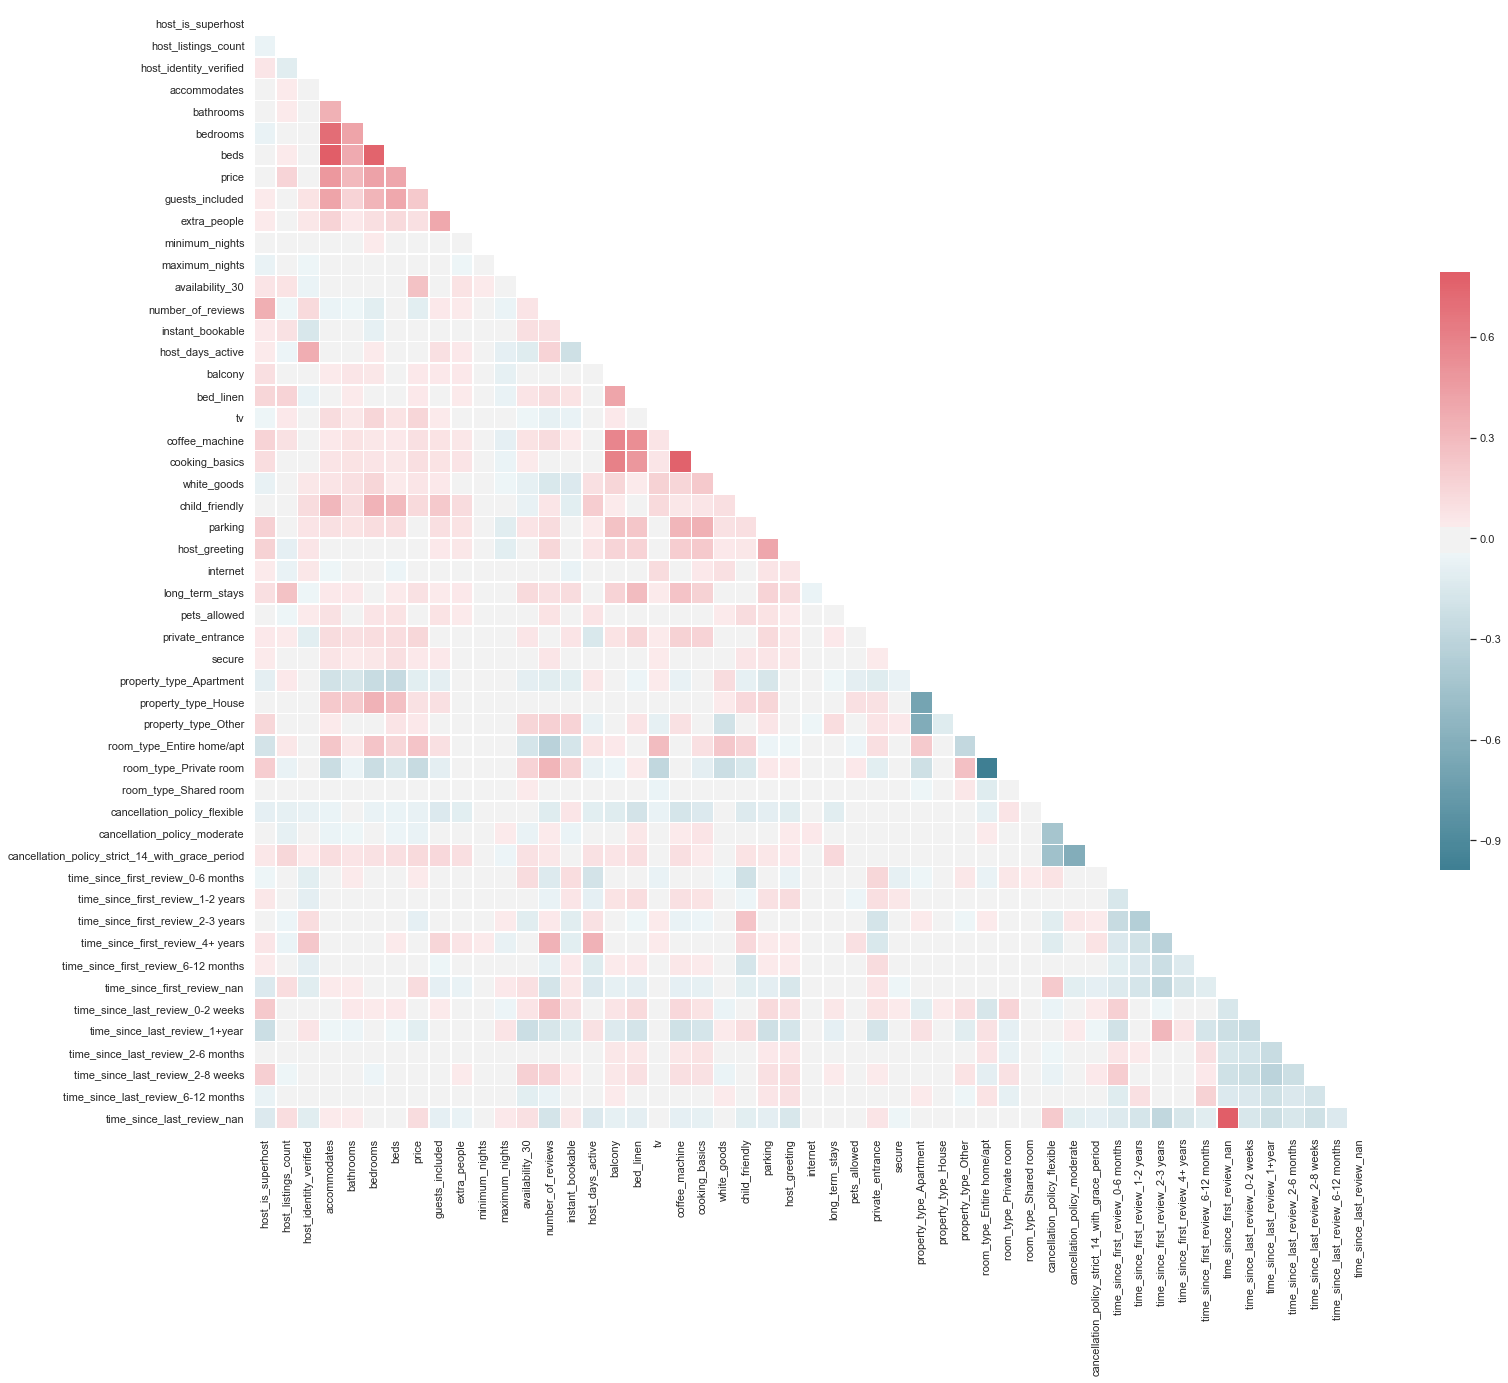

In [87]:
multi_collinearity_heatmap(transformed_df.drop(list(transformed_df.columns[transformed_df.columns.str.startswith('neighbourhood')]), axis=1), figsize=(25,22))

### Multicollinearity Features
#### Beds, bedrooms, guests_included and the number of people that a property accommodates are highly correlated.The number of people accommodated has traditionally been a more high priority search parameter on Airbnb, as it is more relevant for private and shared rooms than the number of bedrooms (and is still the second highest priority parameter when searching on the site, after dates.

#### There are strong negative correlations between property_type_House and property_type_Apartment, and between room_type_Private room and room_type_Entire_home_apt (as these were the main two categories of their features before they were one-hot encoded).Although these are important categories, one of each will be dropped in order to reduce multi-collinearity (apartments and private rooms, as these are the second most common categories).

#### Surprisingly, there is a high correlation between time_since_first_review_nan and time_since_last_review_nan. So one of them will be removed

In [88]:
#Dropping collinear features
to_drop = ['beds',
           'bedrooms',
           'guests_included', 
           'property_type_Apartment',
           'room_type_Private room',
          'time_since_last_review_nan']
to_drop.extend(list(transformed_df.columns[transformed_df.columns.str.endswith('nan')]))

In [89]:
transformed_df.drop(to_drop, axis=1, inplace=True)

In [90]:
transformed_df.columns

Index(['host_is_superhost', 'host_listings_count', 'host_identity_verified',
       'accommodates', 'bathrooms', 'price', 'extra_people', 'minimum_nights',
       'maximum_nights', 'availability_30', 'number_of_reviews',
       'instant_bookable', 'host_days_active', 'balcony', 'bed_linen', 'tv',
       'coffee_machine', 'cooking_basics', 'white_goods', 'child_friendly',
       'parking', 'host_greeting', 'internet', 'long_term_stays',
       'pets_allowed', 'private_entrance', 'secure',
       'neighbourhood_cleansed_Bijlmer-Centrum',
       'neighbourhood_cleansed_Bijlmer-Oost',
       'neighbourhood_cleansed_Bos en Lommer',
       'neighbourhood_cleansed_Buitenveldert - Zuidas',
       'neighbourhood_cleansed_Centrum-Oost',
       'neighbourhood_cleansed_Centrum-West',
       'neighbourhood_cleansed_De Aker - Nieuw Sloten',
       'neighbourhood_cleansed_De Baarsjes - Oud-West',
       'neighbourhood_cleansed_De Pijp - Rivierenbuurt',
       'neighbourhood_cleansed_Gaasperdam - Drie

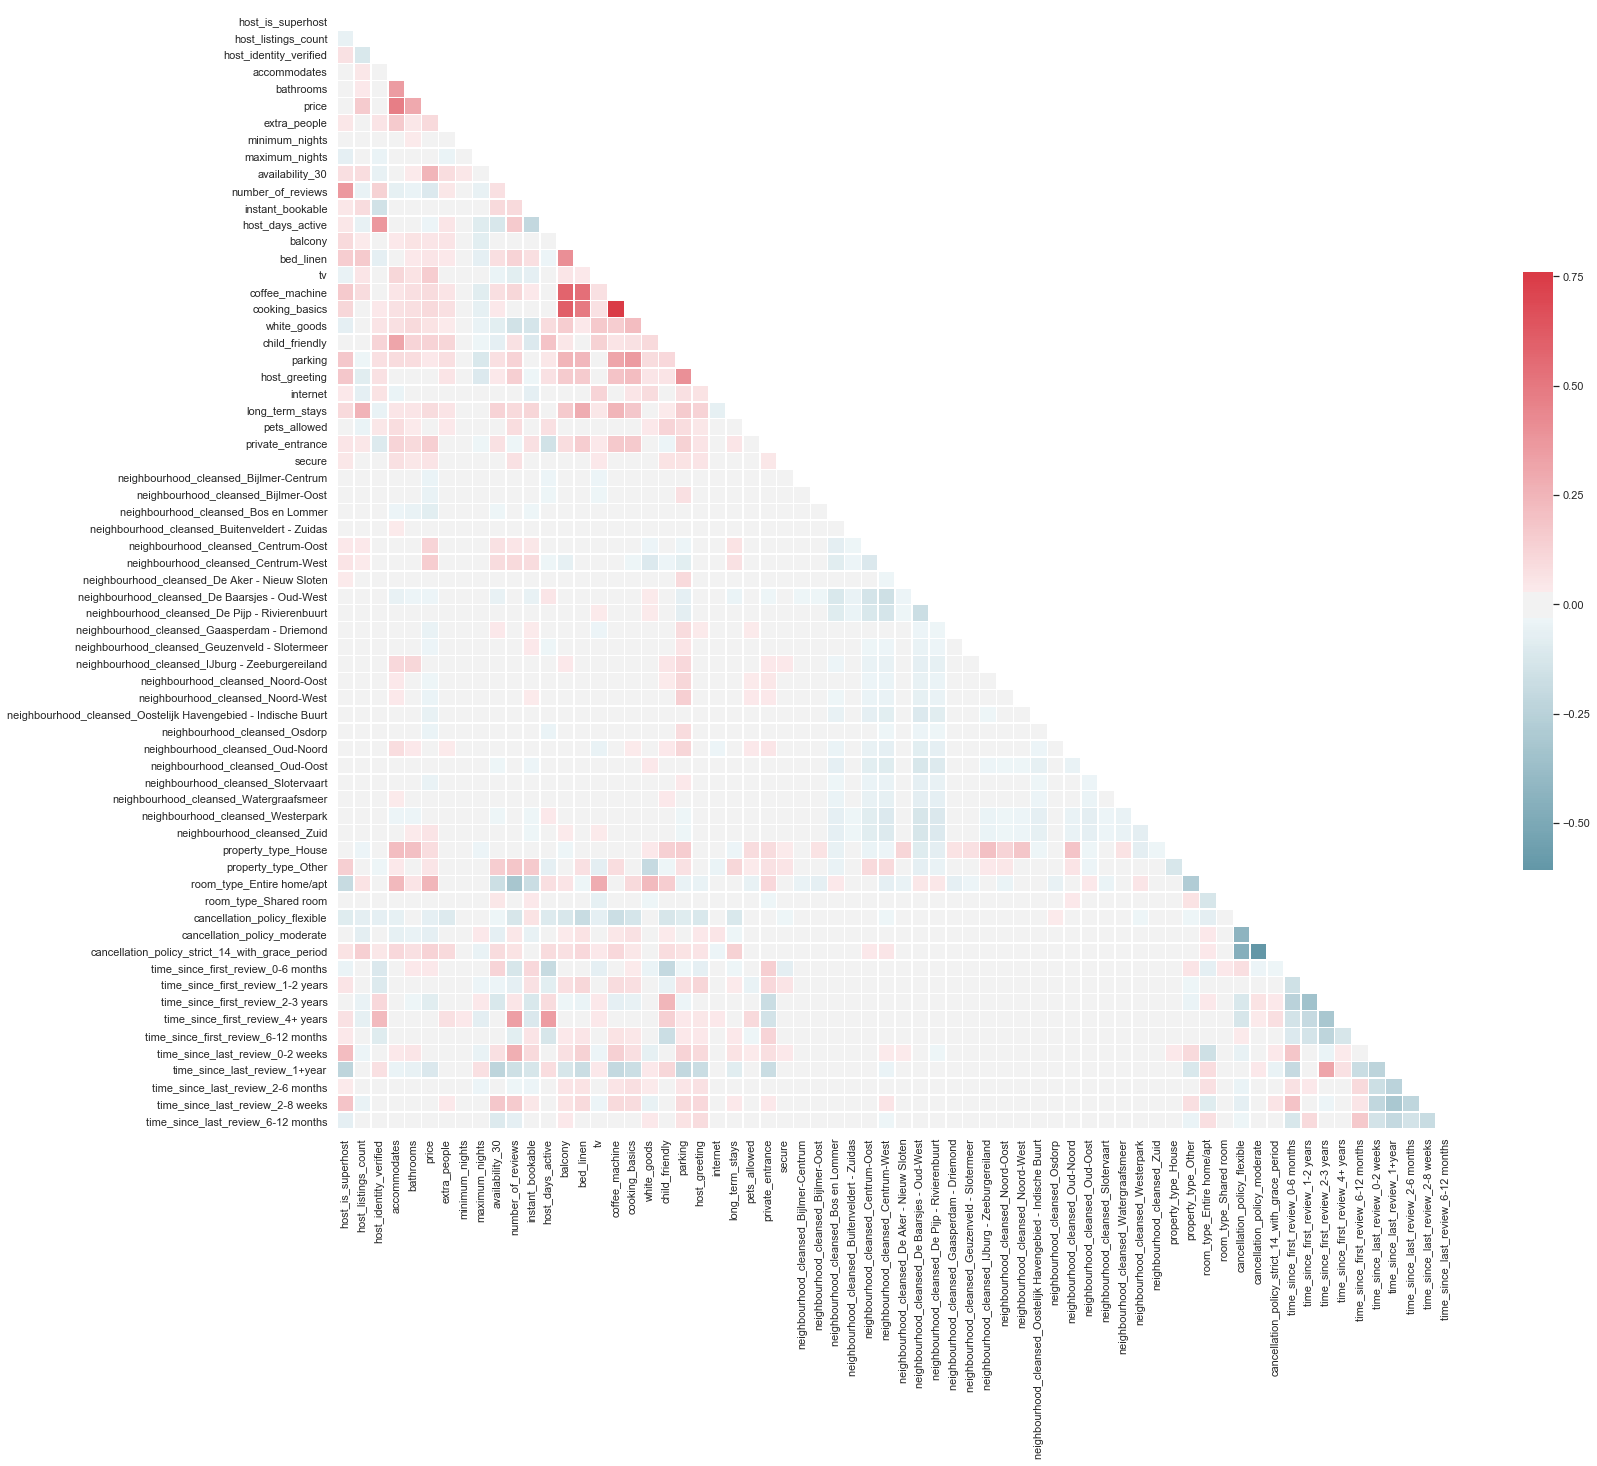

In [91]:
multi_collinearity_heatmap(transformed_df.drop(list(transformed_df.columns[transformed_df.columns.str.startswith('Neighbourhood')]), axis=1), figsize=(25,22))

### Standardising and normalising
#### Other than availability_30 and host_days_active, the remaining numerical features are all postively skewed and could benefit from log transformation.

In [92]:
numerical_columns = ['accommodates', 'availability_30', 'bathrooms',
                    'extra_people', 'host_days_active', 
                     'host_listings_count', 'maximum_nights', 'minimum_nights', 
                     'number_of_reviews', 'price']

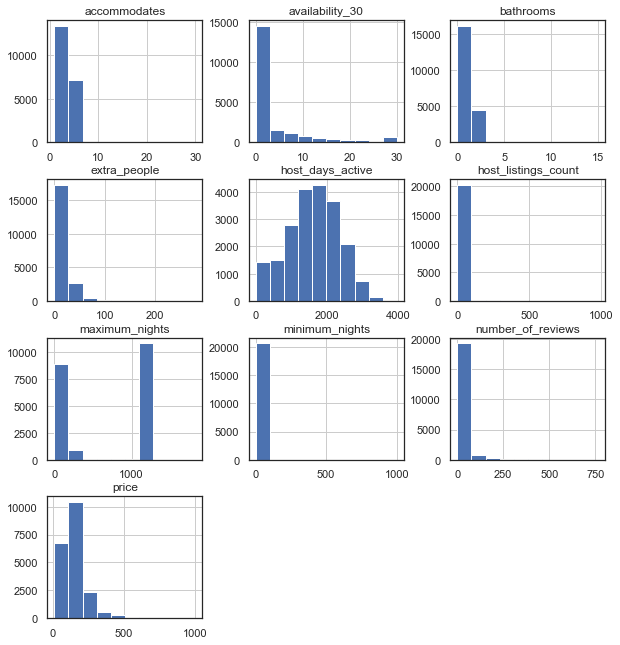

In [93]:
transformed_df[numerical_columns].hist(figsize=(10,11));

In [94]:
# Log transforming columns
numerical_columns = [i for i in numerical_columns 
                     if i not in ['availability_30', 'host_days_active']] # Removing items not to be transformed

for col in numerical_columns:
    transformed_df[col] = transformed_df[col].astype('float64').replace(0.0, 0.01) # Replacing 0s with 0.01
    transformed_df[col] = np.log(transformed_df[col])

This appears to have helped some of the distributions, although some (e.g. bathrooms and host_listings_count) contain a large number of 0s, which means these features are not normally distributed. Most importantly, however, the target variable price now appears much more normally distributed.

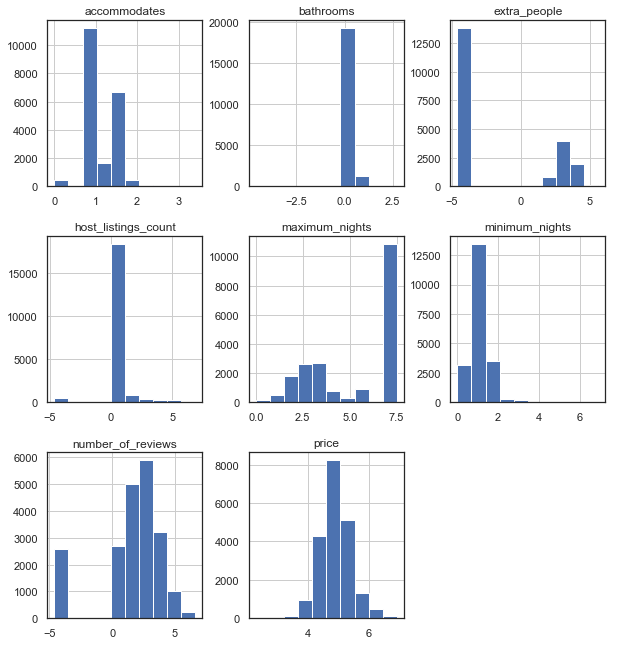

In [95]:
transformed_df[numerical_columns].hist(figsize=(10,11));

#### Finally, the predictive features X and the target feature y can be separated, and X will be scaled. StandardScaler from sklearn will be used, but the type of scaling used could be experimented with later to see if alternative versions yield better results.

In [96]:
# Separating X and y
X = transformed_df.drop('price', axis=1)
y = transformed_df.price

# Scaling
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))

### Modelling

In [97]:
# Splitting into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

### Model1: Gradient Boosting Decision Trees
Gradient boosting is an approach where new models are created that predict the residuals or errors of prior models and then added together to make the final prediction.It is gradient boosting because it uses a gradient descent algorithm to minimize the loss when adding new models.<br />
XGBoost (eXtreme Gradient Boosting) is an implementation of gradient boosted decision trees designed for speed and performance. Is a very popular algorithm that has recently been dominating applied machine learning for structured or tabular data.

In [98]:
xgb_reg_start = time.time()

xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)
training_preds_xgb_reg = xgb_reg.predict(X_train)
val_preds_xgb_reg = xgb_reg.predict(X_test)

xgb_reg_end = time.time()

print(f"Time taken to run: {round((xgb_reg_end - xgb_reg_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_xgb_reg),4))
print("Validation MSE:", round(mean_squared_error(y_test, val_preds_xgb_reg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_xgb_reg),4))

Time taken to run: 0.1 minutes

Training MSE: 0.1137
Validation MSE: 0.119

Training r2: 0.5694
Validation r2: 0.5287


### Here R2 means that our features explain 56% of our target variable('price')

### Feature Importance<br /> A benefit of using ensembles of decision tree methods like gradient boostings is that they provide featurre importance of ourr trained predictive model.<br /> This importance is calculated explicitly for each attribute in the dataset, allowing attributes to be ranked and compared to each other.

#### Importance is calculated for a single decision tree by the amount that each attribute split point improves the performance measure, weighted by the number of observations the node is responsible for. The performance measure may be the purity (Gini index) used to select the split points or another more specific error function.<br /> The feature importances are then averaged across all of the the decision trees within the model.

In [99]:
weights_xgb_reg = pd.DataFrame(xgb_reg.feature_importances_, columns=['weight'], index=X_train.columns)
weights_xgb_reg.sort_values('weight', ascending=False, inplace=True)
weights_xgb_reg.head(10)

,weight
availability_30,0.128093
accommodates,0.110626
extra_people,0.082969
number_of_reviews,0.055313
host_days_active,0.053857
minimum_nights,0.053857
bathrooms,0.049491
neighbourhood_cleansed_Centrum-West,0.043668
host_listings_count,0.040757
room_type_Entire home/apt,0.033479


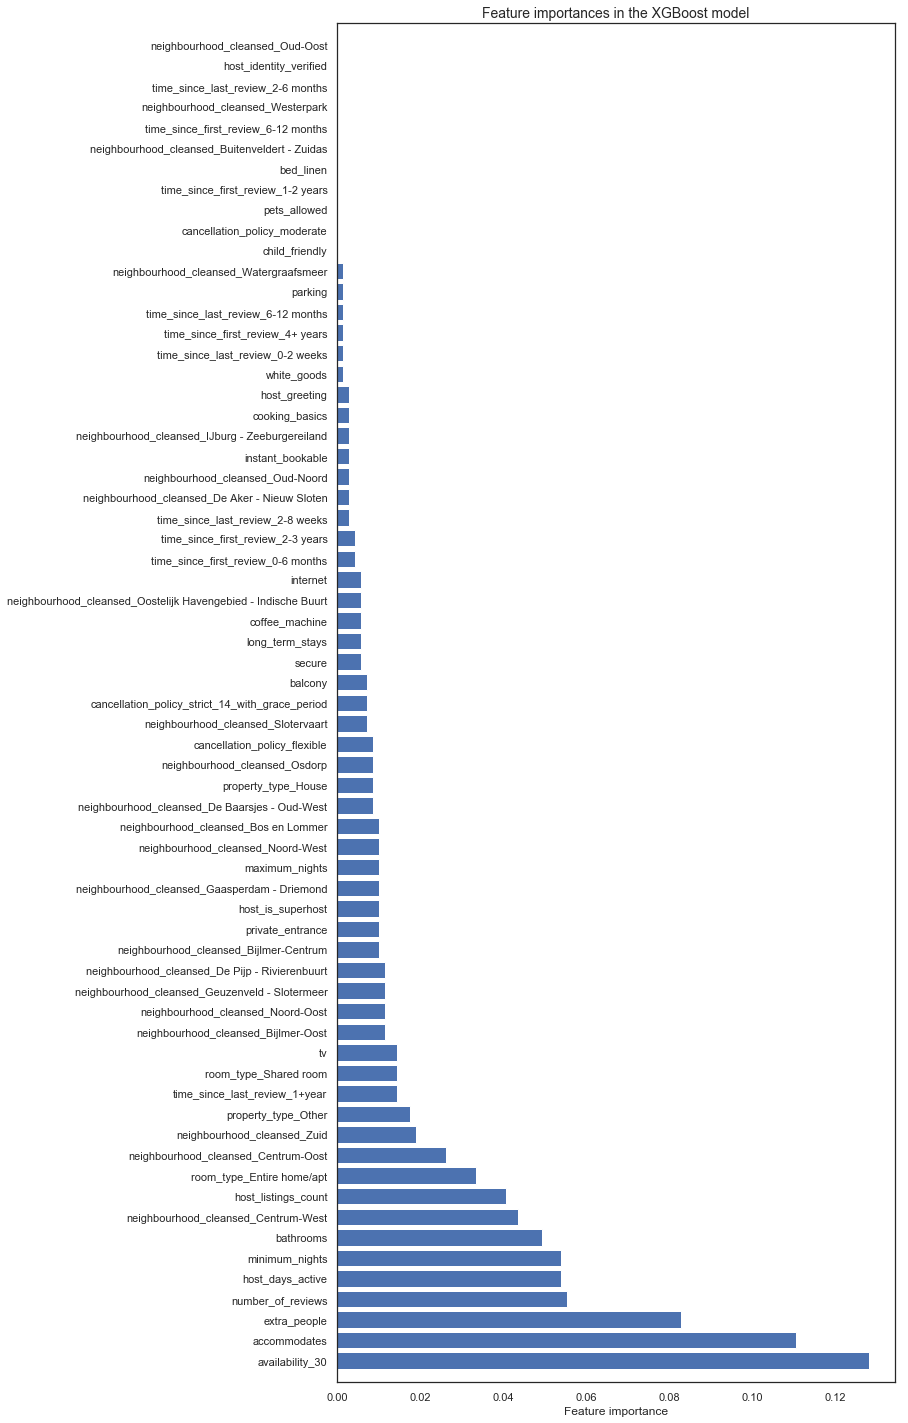

In [100]:
# Plotting feature importances
plt.figure(figsize=(10,25))
plt.barh(weights_xgb_reg.index, weights_xgb_reg.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

About a some number of features have a feature importance of 0 in this XGBoost regression model, and could potentially be removed.
### The top 10 features of our model are:
1.availability_30<br />
2.accommodates<br />
3.extra_people<br />
4.number_of_reviews<br />
5.host_days_active<br />
6.minimum_nights<br />
7.bathrooms<br />
8.neighbourhood_cleansed_Centrum-West<br />
9.host_listings_count<br />
10.room_type_Entire home/apt<br />

### The most important feature is availability_30 which is of no surprise because the first thing when we search is whether it is available or not.
It is not surprising that the second how many people the property accommodates, as that's one of the main things you would use to search for properties with in the first place.<br />
number of reviews is the fourth. Probably, guests feel that higher the number of reviews, good the house is<br />
Host_days_active is fifth. This can be because may be the high the number of days host_is active, the better the experience would be.<br />
The ninth most important feature is related to how many other listings the host manages on Airbnb, rather than the listing itself.<br />
An analysis on airbnb newyork listings explains that this does not mean that a host that manages more properties will result in a listing gaining higher prices, and could be due to experienced hosts setting higher prices. Also, it could be that big Airbnb management companies that have lots of listings tend to manage more expensive properties than single listing hosts.

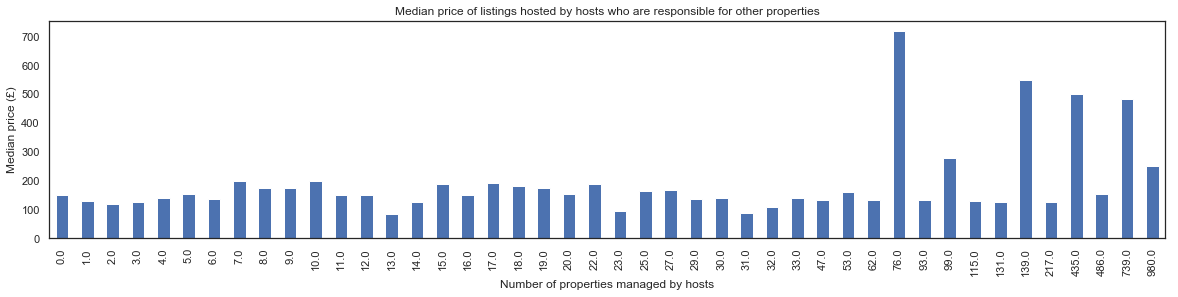

In [101]:
# Median price for different host listing counts
plt.figure()
listings.groupby('host_listings_count').price.median().plot(figsize=(20,4), kind='bar',color='C0')
plt.title('Median price of listings hosted by hosts who are responsible for other properties')
plt.xlabel('Number of properties managed by hosts')
plt.ylabel('Median price (£)');

### Building a pipeline with different  regressors to see if any other are better than gradient boost regressor.

In [102]:
seed = 123
pipelines = []

pipelines.append(
                ("Ridge", 
                 Pipeline([
                      
                     ("Ridge", Ridge(random_state=seed, tol=10 ))
                      ]))
                )
pipelines.append(
                ("Lasso", 
                 Pipeline([
                      
                     ("Lasso", Lasso(random_state=seed, tol=1))
                      ]))
                )
pipelines.append(
                ("Elastic", 
                 Pipeline([
                      
                     ("Lasso", ElasticNet(random_state=seed))
                      ]))
                )

pipelines.append(
                ("RF_reg",
                 Pipeline([
                     
                     ("RF", RandomForestRegressor(random_state=seed))
                 ])
                )
                )

pipelines.append(
                ("ET_reg",
                 Pipeline([
                     
                     ("ET", ExtraTreesRegressor(random_state=seed))
                 ])
                )
                )
pipelines.append(
                ("BR_reg",
                 Pipeline([
                     
                     ("BR", BaggingRegressor(random_state=seed))
                 ]))) 

pipelines.append(
                ("Hub-Reg",
                 Pipeline([
                     
                     ("Hub-Reg", HuberRegressor())
                 ]))) 

pipelines.append(
                ("DT_reg",
                 Pipeline([
                     
                     ("DT_reg", DecisionTreeRegressor())
                 ]))) 

pipelines.append(
                ("KNN_reg",
                 Pipeline([
                     
                     ("KNN_reg", KNeighborsRegressor())
                 ])))

pipelines.append(
                ("Gboost-Reg",
                 Pipeline([
                     
                     ("GBoost-Reg", GradientBoostingRegressor())
                 ])))


In [ ]:
scoring = 'r2'
n_folds = 5

results, names  = [], [] 

for name, model  in pipelines:
    kfold = KFold(n_splits=n_folds, random_state=seed)
    cv_results = cross_val_score(model, X, y, cv= kfold,
                                 scoring=scoring, n_jobs=-1)    
    names.append(name)
    results.append(cv_results)    
    msg = "%s: %f (+/- %f)" % (name, cv_results.mean(),  cv_results.std())
    print(msg)

Ridge: 0.516062 (+/- 0.024055)
Lasso: -0.017484 (+/- 0.018175)
Elastic: -0.017484 (+/- 0.018175)
RF_reg: 0.450848 (+/- 0.033558)
ET_reg: 0.414646 (+/- 0.034052)
BR_reg: 0.452607 (+/- 0.034372)
Hub-Reg: 0.514467 (+/- 0.027025)
DT_reg: 0.014628 (+/- 0.053700)
KNN_reg: 0.281865 (+/- 0.034837)


### Final model selection
Overall, the XGBoost model is the preferred model, which performs better than all the models built including a Neural network, just as good as the first model but is less computationally expensive. It could possibly be improved further with hyper-parameter tuning.<br />
I have tried Neural networks but it gave worst of all results.

### Conclusions and Recommendations
The best performing model was able to predict 56.94% of the variation in price with an RMSE of 0.11. Which means we still have a remaining 43.04% unexplained. This could be due to several other features that are not part of our dataset or the need to analyse our features more closely.

For example, given the importance of customer reviews of the listing in determining price, perhaps a better understanding of the reviews could improve the prediction. Using Sentiment Analysis, a score between -1 (very negative sentiment) and 1 (very positive sentiment) can be assigned to each review per listing property. The scores are then averaged across all the reviews associated with that listing and the final scores can be included as a new feature in the model.

Another suggestion is the inclusion of image quality as a feature. Using Difference-in-Difference deep learning and supervised learning analyses on a Airbnb panel dataset, researchers found that units with verified photos (taken by Airbnb’s photographers) generate additional revenue per year on average.

Highlighting accessibility and location benefits of staying with them could perhaps benefit them and how much they can ask for their listing.